# Analysis of Cancer Signatures and *(Maybe :P)* Drug Repurposing

**Project:** Tumor-Normal Signature Analysis for Cancer Classification and Drug Prediction

**Description:**
This notebook presents a comprehensive bioinformatics sadsd:
1.  **Data Acquisition:** Downloads and preprocesses cancer gene expression datasets from the Gene Expression Omnibus (GEO).
2.  **Probe Annotation and Expression Matrix Collapse:** Preprocessing Microarray data mapping platform-specific probe IDs to standardized HGNC gene symbols
3.  **Signature Generation:** Extracting differential expression signature (Tumor - Normal).
4.  **Unsupervised Learning:** Utilizes PCA, UMAP, and hierarchical clustering to visualize relationships between signatures and cancer types.
5.  **Supervised Learning & Pathway Enrichment:** Trains a Random Forest model with nested cross-validation to classify cancer types and model evaluation afterwards. Identifies key biological pathways associated with the most predictive genes.
6.  **Drug Prediction:** Applies the trained model to the LINCS L1000 drug dataset to predict which compounds may be effective against specific cancer types.

## 0.Setup and Library Installation

This initial step installs and imports all necessary libraries for the analysis. We will also configure plotting styles to have a match theme through the notebook.

### Noteboook dependencies
*As always a conda enviroment is recommended for easier installation*

In [101]:
pip install pandas numpy matplotlib seaborn plotly colorcet GEOparse mygene cmapPy gseapy scikit-learn umap-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [102]:
# Standard library
import os
import re
import sys
import glob


# Data & numerics
import pandas as pd
import numpy as np
from typing import List, Tuple, Optional


# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import colorcet as cc
from matplotlib.patches import Patch
from sklearn.preprocessing import StandardScaler
from matplotlib import gridspec
from scipy.cluster.hierarchy import linkage, leaves_list, dendrogram
from scipy.spatial.distance import pdist


# Bioinformatics & data access
import GEOparse
from mygene import MyGeneInfo
from cmapPy.pandasGEXpress.parse import parse
import gseapy

# Machine learning
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    )
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, silhouette_score
from scipy.spatial.distance import cdist

# Dimensionality reduction
import umap

# Utils
_MG = MyGeneInfo()
print("All libraries are loaded and configured.")

# Plots
dir_plot = "/home/kousis/work/BCProjects/drugs_plots"
os.makedirs(dir_plot, exist_ok=True)

def save_fig(filename: str, fig=None, *, dpi: int = 300, close: bool = False) -> str:
    """Persist a Matplotlib figure to the shared plot directory."""
    fig = fig if fig is not None else plt.gcf()
    path = os.path.join(dir_plot, filename)
    fig.savefig(path, dpi=dpi, bbox_inches="tight")
    print(f"Saved figure to {path}")
    if close:
        plt.close(fig)
    return path

def save_plotly(fig, filename_html: str, *, image_filename: Optional[str] = None) -> str:
    """Write Plotly figures to HTML (and optionally static image when kaleido is available)."""
    html_path = os.path.join(dir_plot, filename_html)
    fig.write_html(html_path)
    print(f"Saved Plotly HTML to {html_path}")
    if image_filename:
        image_path = os.path.join(dir_plot, image_filename)
        try:
            fig.write_image(image_path)
            print(f"Saved Plotly image to {image_path}")
        except Exception as exc:
            print(f"Plotly static export skipped ({exc})")
    return html_path

All libraries are loaded and configured.


## 1.Data Acquisition

Begin by defining the list of cancer datasets (GSE series) to be analyzed. A helper function, `download_geo`, will download the expression and phenotype data for each dataset from GEO, skipping any that are already downloaded. If u are repoducing this pipeline feel free to put you own codes or modify download dir if u already have available data

### 1.1: Function to Download GEO Data

In [103]:
download_data = "./GEO_raw" # Directory to store downloaded GEO data, affects download_geo function

In [104]:
def download_geo(gse_id, dest=download_data):
    """
    Downloads and caches GEO datasets (expression and phenotype).
    Skips download if both files already exist.
    """
    os.makedirs(dest, exist_ok=True)
    expr_path = os.path.join(dest, f"{gse_id}_expr.csv")
    pheno_path = os.path.join(dest, f"{gse_id}_pheno.csv")

    if os.path.exists(expr_path) and os.path.exists(pheno_path):
        print(f"INFO: {gse_id} data already exists. Skipping download.")
        return expr_path, pheno_path

    if os.path.exists(expr_path) or os.path.exists(pheno_path):
        print(f"WARN: Found partial files for {gse_id}. Regenerating both.")

    print(f"ACTION: Downloading {gse_id} from GEO...")
    try:
        gse = GEOparse.get_GEO(geo=gse_id, destdir=dest, silent=True)
        expr = gse.pivot_samples('VALUE')
        pheno = gse.phenotype_data
        expr.to_csv(expr_path)
        pheno.to_csv(pheno_path)
        print(f"SUCCESS: Saved {expr_path} & {pheno_path}")
        return expr_path, pheno_path
    except Exception as e:
        print(f"ERROR: Failed to download {gse_id}. Reason: {e}")
        return None, None

In [105]:
datasets = {
    "ESCC": "GSE38129",      # Esophageal squamous cell carcinoma
    "STAD": "GSE65801",      # Gastric adenocarcinoma
    "LUAD": "GSE19804",      # Lung adenocarcinoma
    "KIRC": "GSE53757",      # Clear cell renal cell carcinoma
    "THCA": "GSE33630",      # Papillary thyroid carcinoma
    "HNSC": "GSE6631",       # Head & neck squamous cell carcinoma
    "COAD": "GSE74602",      # Colon adenocarcinoma
    "LIHC": "GSE57957",      # Hepatocellular carcinoma
    "BRCA": "GSE15852",      # Breast cancer
    "COAD_2": "GSE44076",    # Colorectal cancer
    "LUAD_2": "GSE10072",    # Lung adenocarcinoma
    "LC": "GSE33356",        # Lung Cancer
}

In [106]:
for name, gse_id in datasets.items():
    print(f"\nProcessing Dataset: {name} ({gse_id})")
    download_geo(gse_id)


Processing Dataset: ESCC (GSE38129)
INFO: GSE38129 data already exists. Skipping download.

Processing Dataset: STAD (GSE65801)
INFO: GSE65801 data already exists. Skipping download.

Processing Dataset: LUAD (GSE19804)
INFO: GSE19804 data already exists. Skipping download.

Processing Dataset: KIRC (GSE53757)
INFO: GSE53757 data already exists. Skipping download.

Processing Dataset: THCA (GSE33630)
INFO: GSE33630 data already exists. Skipping download.

Processing Dataset: HNSC (GSE6631)
INFO: GSE6631 data already exists. Skipping download.

Processing Dataset: COAD (GSE74602)
INFO: GSE74602 data already exists. Skipping download.

Processing Dataset: LIHC (GSE57957)
INFO: GSE57957 data already exists. Skipping download.

Processing Dataset: BRCA (GSE15852)
INFO: GSE15852 data already exists. Skipping download.

Processing Dataset: COAD_2 (GSE44076)
INFO: GSE44076 data already exists. Skipping download.

Processing Dataset: LUAD_2 (GSE10072)
INFO: GSE10072 data already exists. Skipp

## 2.Probe Annotation and Expression Matrix Collapse

**Unfortunatly** Microarray data requires a preprocessing step: mapping platform-specific probe IDs to standardized HGNC gene symbols. Since multiple probes can target the same gene, we must also collapse these probes into a single representative value for each gene. Here, I used the probe with the highest variance as the representative, since will probably be of more use.

### 2.1: Annotation and Collapsing

In [107]:
# For this block LLM were used heavily to help with parsing and mapping gene symbols from various GPL annotation formats. This too much be modularised into a package but for now its ok like this
# Manually Curated 
def _first_symbol(x: str) -> str:
    if x is None:
        return ""
    s = str(x)
    # Common multi-symbol separators in GPL tables
    s = re.split(r"\s*[;,/|]+\s*|\s+///\s+|\s+//\s+", s)[0]
    s = s.strip()
    return s


def _harmonize_symbols(symbols):
    """Map a list of gene symbols/aliases to current HGNC symbols using mygene, if available."""
    if _MG is None or not symbols:
        return {s: s for s in symbols}
    uniq = sorted({s for s in symbols if s})
    try:
        out = _MG.querymany(
            uniq,
            scopes="symbol,alias,previous_symbol,name",
            fields="symbol,taxid",
            species="human",
            as_dataframe=False,
            returnall=False,
            verbose=False,
        )
        mapping = {}
        for rec in out:
            q = rec.get('query')
            if rec.get('notfound'):
                mapping[q] = q
            else:
                sym = rec.get('symbol') or q
                mapping[q] = sym
        return mapping
    except Exception:
        # Graceful fallback
        return {s: s for s in symbols}


def _map_entrez_to_symbol(entrez_ids):
    """Map a list of Entrez Gene IDs to HGNC symbols using mygene (if available)."""
    if _MG is None or not entrez_ids:
        return {}
    # Clean and unique numeric IDs as strings
    ids = [str(e).strip() for e in entrez_ids if str(e).strip().isdigit()]
    ids = sorted(set(ids))
    if not ids:
        return {}
    try:
        out = _MG.querymany(ids, scopes="entrezgene", fields="symbol", species="human", as_dataframe=False, returnall=False, verbose=False)
        m = {}
        for rec in out:
            q = str(rec.get('query', ''))
            sym = rec.get('symbol')
            if q and sym:
                m[q] = sym
        return m
    except Exception:
        return {}


def _parse_gene_assignment(val: str):
    """Parse Affymetrix Gene ST 'gene_assignment' style fields.
    Returns (symbol, entrez) where either may be None.
    Heuristics: split on '///', '//', ';', '|', ',' and whitespace groups; first non-numeric token ~ symbol; first integer token ~ entrez.
    """
    if val is None:
        return None, None
    s = str(val)
    parts = re.split(r"\s*///\s*|\s*//\s*|\s*[;|,]\s*|\s+\|\s+", s)
    sym = None
    ent = None
    for p in parts:
        t = p.strip()
        if not t:
            continue
        # Capture first integer-like as Entrez
        if ent is None and re.fullmatch(r"\d{2,}", t):
            ent = t
        # Capture first plausible symbol token (letters/digits/hyphen/dot) not purely numeric
        if sym is None and re.fullmatch(r"[A-Za-z][A-Za-z0-9_.-]*", t) and not t.isdigit():
            # avoid common non-genes
            if t.upper() not in {"---", "NR", "NA"}:
                sym = t
    return sym, ent


def build_probe_symbol_map(gse) -> dict:
    """Build probe->HGNC symbol map from all GPL tables in a GSE.
    Supports common columns and Affymetrix ST 'gene_assignment' parsing;
    falls back to Entrez ID mapping via mygene when symbols are missing.
    """
    # Common symbol and Entrez columns
    symbol_cols = [
        'Gene Symbol','GENE_SYMBOL','Symbol','GeneSymbol','Gene symbol',
        'ENTREZ_GENE_SYMBOL','Entrez Gene Symbol','Associated Gene Symbol',
        'gene_assignment','Gene Assignment','gene assignment'
    ]
    entrez_cols = [
        'ENTREZ_GENE_ID','Entrez Gene','ENTREZ_GENE','Entrez ID','ENTREZID','Gene ID','Entrez_Gene_ID'
    ]
    id_col = 'ID'
    probe_to_symbol: dict[str, str] = {}
    probe_to_entrez: dict[str, str] = {}

    for gpl in gse.gpls.values():
        df = gpl.table
        # Identify probe ID column (case-insensitive)
        local_id_col = id_col
        if local_id_col not in df.columns:
            id_like = [c for c in df.columns if c.strip().lower() == 'id']
            if id_like:
                local_id_col = id_like[0]
            else:
                continue

        # Prefer explicit symbol columns first
        sym_col = None
        for c in symbol_cols:
            if c in df.columns:
                sym_col = c
                break
        # Collect explicit symbol mappings
        if sym_col and sym_col.lower().startswith('gene_assignment'):
            tmp = df[[local_id_col, sym_col]].dropna()
            for pid, raw in zip(tmp[local_id_col].astype(str), tmp[sym_col].astype(str)):
                sym, ent = _parse_gene_assignment(raw)
                if sym and pid not in probe_to_symbol:
                    probe_to_symbol[pid] = sym
                if ent and pid not in probe_to_entrez:
                    probe_to_entrez[pid] = ent
        elif sym_col:
            tmp = df[[local_id_col, sym_col]].dropna()
            tmp[sym_col] = tmp[sym_col].map(_first_symbol)
            tmp = tmp[tmp[sym_col].astype(str).str.len() > 0]
            for pid, sym in zip(tmp[local_id_col].astype(str), tmp[sym_col].astype(str)):
                if pid not in probe_to_symbol:
                    probe_to_symbol[pid] = sym
        # Collect Entrez IDs from common columns for fallback
        ent_col = None
        for c in entrez_cols:
            if c in df.columns:
                ent_col = c
                break
        if ent_col:
            tmp = df[[local_id_col, ent_col]].dropna()
            for pid, ent in zip(tmp[local_id_col].astype(str), tmp[ent_col].astype(str)):
                # Pick first numeric token in case of multi-valued fields
                m = re.search(r"\b(\d{2,})\b", ent)
                if m and pid not in probe_to_entrez:
                    probe_to_entrez[pid] = m.group(1)

    # Fallback: map Entrez to symbols for probes without symbols
    if probe_to_entrez:
        entrez_map = _map_entrez_to_symbol(list(probe_to_entrez.values()))
        for pid, ent in probe_to_entrez.items():
            if pid not in probe_to_symbol and ent in entrez_map:
                probe_to_symbol[pid] = entrez_map[ent]

    # Harmonize to current HGNC if possible
    if probe_to_symbol:
        sym_map = _harmonize_symbols(list(set(probe_to_symbol.values())))
        probe_to_symbol = {p: sym_map.get(s, s) for p, s in probe_to_symbol.items()}
    return probe_to_symbol

def collapse_by_method(expr: pd.DataFrame, genes: pd.Series, method: str = 'max_var', pheno: pd.DataFrame | None = None):
    """Collapse multiple probes per gene to a single row.
    - max_var: pick the probe with highest variance across samples per gene.
    - mean: average expression of probes per gene.
    - effect: if pheno allows tumor/normal grouping, choose probe with largest |mean(tumor)-mean(normal)|; fallback to max_var.
    """
    df = expr.copy()
    df['__gene__'] = genes.values
    df = df[~df['__gene__'].isna() & (df['__gene__'] != '')]
    if method == 'mean':
        out = df.groupby('__gene__').mean(numeric_only=True)
        return out
    # max_var (default)
    expr_only = df.drop(columns=['__gene__'])
    var = expr_only.var(axis=1, ddof=1)
    df['__var__'] = var
    winners = df.sort_values(['__gene__', '__var__'], ascending=[True, False]) \
                .drop_duplicates(subset='__gene__', keep='first')
    out = winners.set_index('__gene__').drop(columns=['__var__'])
    return out


def annotate_and_collapse(gse_id: str, dest: str = './GEO_raw', outdir: str = './annotated', method: str = 'max_var'):
    os.makedirs(outdir, exist_ok=True)
    expr_path = os.path.join(dest, f"{gse_id}_expr.csv")
    pheno_path = os.path.join(dest, f"{gse_id}_pheno.csv")
    if not os.path.exists(expr_path):
        raise FileNotFoundError(f"Expression file not found: {expr_path}")
    # Load
    expr = pd.read_csv(expr_path, index_col=0)
    pheno = None
    if os.path.exists(pheno_path):
        try:
            pheno = pd.read_csv(pheno_path, index_col=0)
        except Exception:
            pheno = None
    # Fetch GSE (cached) to get GPL mapping
    gse = GEOparse.get_GEO(geo=gse_id, destdir=dest, silent=True)
    probe2sym = build_probe_symbol_map(gse)
    # Map indices
    genes = expr.index.map(lambda p: probe2sym.get(str(p), None))
    mapped = (~pd.isna(genes) & (genes.astype(str) != '')).sum()
    total = len(genes)
    print(f"{gse_id}: mapped {mapped}/{total} probes to symbols.")
    # Keep only mapped and collapse
    expr_mapped = expr.copy()
    expr_mapped.insert(0, '__gene__', genes)
    expr_mapped = expr_mapped[~expr_mapped['__gene__'].isna() & (expr_mapped['__gene__'] != '')]
    collapsed = collapse_by_method(expr_mapped.drop(columns=['__gene__']), expr_mapped['__gene__'], method=method, pheno=pheno)
    annotated_path = os.path.join(outdir, f"{gse_id}_annotated.csv")
    collapsed.to_csv(annotated_path)
    print(f"Saved annotated matrix: {annotated_path} (genes={collapsed.shape[0]}, samples={collapsed.shape[1]})")
    return annotated_path

In [108]:
os.makedirs('annotated', exist_ok=True)

# Configuration to force re-annotation for specific datasets if needed 
OVERWRITE_ANNOTATED = {}

for name, gse_id in datasets.items():
    print(f"\n--- Annotating: {name} ({gse_id}) ---")
    out_file = os.path.join('annotated', f"{gse_id}_annotated.csv")
    if os.path.exists(out_file) and gse_id not in OVERWRITE_ANNOTATED:
        print(f"INFO: Already annotated: {out_file}. Skipping.")
        continue
    try:
        annotate_and_collapse(gse_id, dest=download_data, outdir='./annotated') # This theoraticly can be modularised, now as it annotated is default dir
    except Exception as e:
        print(f"ERROR: Failed to annotate {name} ({gse_id}). Reason: {e}")


--- Annotating: ESCC (GSE38129) ---
INFO: Already annotated: annotated/GSE38129_annotated.csv. Skipping.

--- Annotating: STAD (GSE65801) ---
INFO: Already annotated: annotated/GSE65801_annotated.csv. Skipping.

--- Annotating: LUAD (GSE19804) ---
INFO: Already annotated: annotated/GSE19804_annotated.csv. Skipping.

--- Annotating: KIRC (GSE53757) ---
INFO: Already annotated: annotated/GSE53757_annotated.csv. Skipping.

--- Annotating: THCA (GSE33630) ---
INFO: Already annotated: annotated/GSE33630_annotated.csv. Skipping.

--- Annotating: HNSC (GSE6631) ---
INFO: Already annotated: annotated/GSE6631_annotated.csv. Skipping.

--- Annotating: COAD (GSE74602) ---
INFO: Already annotated: annotated/GSE74602_annotated.csv. Skipping.

--- Annotating: LIHC (GSE57957) ---
INFO: Already annotated: annotated/GSE57957_annotated.csv. Skipping.

--- Annotating: BRCA (GSE15852) ---
INFO: Already annotated: annotated/GSE15852_annotated.csv. Skipping.

--- Annotating: COAD_2 (GSE44076) ---
INFO: Alr

## 3.Signature Generation

A differential expression signature (Tumor - Normal) can capture the gene expression changes specific to a patient's cancer. This section identifies matched tumor-normal pairs from the metadata and computes these signatures. The reason this approach was used is because is closer to l1000 logic. Also this is pretty common in cancer genomics. 

### 3.1: Functions for Pair Identification and Signature Computation
I lost 20 years of my life trying to create a general rule to account for all the different forms of annoations... my will is degenreating as I am getting older...I hard coded the edge cases for each of the dataset, GEO annotation inconsistency must be assessed! Maybe a meta-analysis through out the years with entropy of annotation columns.

In [109]:
def get_pairs(gse_id, pheno):
    """
    Detect tumor/normal matched pairs using dataset-specific rules.
    Returns a list of (tumor_sid, normal_sid) tuples.
    """
    pairs = []
    if pheno is None or pheno.empty:
        return []

    # Ensure index is string for consistent matching
    pheno.index = pheno.index.astype(str)

    # GSE38129 (ESCC)
    if gse_id == 'GSE38129':
        t_map, n_map = {}, {}
        for sid, row in pheno.iterrows():
            val = str(row.get('title', ''))
            m = re.search(r'^E(\d+)([NT])$', val.strip(), re.I)
            if m:
                subj_id, tissue_type = m.group(1), m.group(2).upper()
                if tissue_type == 'T': t_map[subj_id] = row['geo_accession']
                elif tissue_type == 'N': n_map[subj_id] = row['geo_accession']
        for subj_id in sorted(set(t_map) & set(n_map)):
            pairs.append((t_map[subj_id], n_map[subj_id]))

    # GSE65801 (STAD)
    elif gse_id == 'GSE65801':
        t_map, n_map = {}, {}
        for sid, row in pheno.iterrows():
            title = str(row.get('title', ''))
            m = re.search(r'gastric_(tumor|normal)_(\d+)', title, re.I)
            if m:
                tissue_type, subj_id = m.group(1).lower(), m.group(2)
                if tissue_type == 'tumor': t_map[subj_id] = row['geo_accession']
                elif tissue_type == 'normal': n_map[subj_id] = row['geo_accession']
        for subj_id in sorted(set(t_map) & set(n_map)):
            pairs.append((t_map[subj_id], n_map[subj_id]))



    # GSE6631 (HNSC)
    elif gse_id == 'GSE6631':
        t_map, n_map = {}, {}
        for sid, row in pheno.iterrows():
            title = str(row.get('title', ''))
            m_cancer = re.search(r'Cancer (\d+)', title, re.I)
            m_normal = re.search(r'Normal mucosa (\d+)', title, re.I)
            if m_cancer: t_map[m_cancer.group(1)] = row['geo_accession']
            elif m_normal: n_map[m_normal.group(1)] = row['geo_accession']
        for subj_id in sorted(set(t_map) & set(n_map)):
            pairs.append((t_map[subj_id], n_map[subj_id]))

    # GSE15852 (BRCA)
    elif gse_id == 'GSE15852':
        t_map, n_map = {}, {}
        for sid, row in pheno.iterrows():
            title = str(row.get('title', ''))
            m = re.search(r'\b(BC\d+)([NT])\b', title, re.I)
            if m:
                subj_id, tissue_type = m.group(1), m.group(2).upper()
                if tissue_type == 'T': t_map[subj_id] = row['geo_accession']
                elif tissue_type == 'N': n_map[subj_id] = row['geo_accession']
        for subj_id in sorted(set(t_map) & set(n_map)):
            pairs.append((t_map[subj_id], n_map[subj_id]))

    # GSE19804 (LUAD)
    elif gse_id == 'GSE19804':
        t_map, n_map = {}, {}
        for sid, row in pheno.iterrows():
            title = str(row.get('title', ''))
            m = re.search(r'(\d+)([NT])$', title.strip(), re.I)
            if m:
                subj_id, tissue_type = m.group(1), m.group(2).upper()
                if tissue_type == 'T': t_map[subj_id] = row['geo_accession']
                elif tissue_type == 'N': n_map[subj_id] = row['geo_accession']
        for subj_id in sorted(set(t_map) & set(n_map)):
            pairs.append((t_map[subj_id], n_map[subj_id]))

    # GSE74602 (COAD)
    elif gse_id == 'GSE74602':
        t_map, n_map = {}, {}
        for sid, row in pheno.iterrows():
            source_name = str(row.get('source_name_ch1', ''))
            m = re.search(r'\b(T|N)(\d+)\b', source_name)
            if m:
                tissue_type, subj_id = m.group(1).upper(), m.group(2)
                if tissue_type == 'T': t_map[subj_id] = row['geo_accession']
                elif tissue_type == 'N': n_map[subj_id] = row['geo_accession']
        for subj_id in sorted(set(t_map) & set(n_map)):
            pairs.append((t_map[subj_id], n_map[subj_id]))

    # GSE33630 (THCA)
    elif gse_id == 'GSE33630':
        t_map, n_map = {}, {}
        for sid, row in pheno.iterrows():
            val = str(row.get('title', ''))
            m = re.search(r'^(\d+)([NT])$', val.strip(), re.I)
            if m:
                subj_id, tissue_type = m.group(1), m.group(2).upper()
                if tissue_type == 'T': t_map[subj_id] = row['geo_accession']
                elif tissue_type == 'N': n_map[subj_id] = row['geo_accession']
        for subj_id in sorted(set(t_map) & set(n_map)):
            pairs.append((t_map[subj_id], n_map[subj_id]))

    # GSE57957 (LIHC)
    elif gse_id == 'GSE57957':
        t_map, n_map = {}, {}
        for sid, row in pheno.iterrows():
            val = str(row.get('title', ''))
            m = re.search(r'HCC_(\d+)([NT])', val, re.I)
            if m:
                subj_id, tissue_type = m.group(1), m.group(2).upper()
                if tissue_type == 'T': t_map[subj_id] = row['geo_accession']
                elif tissue_type == 'N': n_map[subj_id] = row['geo_accession']
        for subj_id in sorted(set(t_map) & set(n_map)):
            pairs.append((t_map[subj_id], n_map[subj_id]))

    # GSE44076 (COAD_2)
    elif gse_id == 'GSE44076':
        pheno['patient_id'] = pheno['title'].str.extract(r'from (\w+) patient')
        pheno['tissue_type'] = pheno['title'].str.extract(r'^(\w+)')
        normals = pheno[pheno['tissue_type'] == 'Normal']
        tumors = pheno[pheno['tissue_type'] == 'Tumor']
        for _, tumor_row in tumors.iterrows():
            patient_id = tumor_row['patient_id']
            if patient_id:
                normal_match = normals[normals['patient_id'] == patient_id]
                if not normal_match.empty:
                    pairs.append((tumor_row['geo_accession'], normal_match.iloc[0]['geo_accession']))
    
    # GSE53757 (KIRC)
    elif gse_id == 'GSE53757':
        pheno = pheno[~pheno['title'].str.startswith(('HRE', 'HKT'))].copy()
        pheno['id'] = pd.to_numeric(pheno['title'].str.extract(r'(\d+)')[0], errors='coerce')
        pheno['type'] = pheno['title'].str.extract(r'([TN])$')[0]
        pheno.dropna(subset=['id', 'type'], inplace=True)
        pheno['id'] = pheno['id'].astype(int)
        tumors = pheno[pheno['type'] == 'T']
        normals = pheno[pheno['type'] == 'N']
        for _, tumor_row in tumors.iterrows():
            expected_normal_id = tumor_row['id'] + 1
            normal_match = normals[normals['id'] == expected_normal_id]
            if not normal_match.empty:
                pairs.append((tumor_row['geo_accession'], normal_match.iloc[0]['geo_accession']))

    # GSE10072 (LUAD_2)
    elif gse_id == 'GSE10072':
        pheno['patient_id'] = pheno['title'].str.split('_').str[1]
        pheno['tissue_type'] = pheno['title'].str.split('_').str[0]
        normals = pheno[pheno['tissue_type'] == 'Normal Lung']
        tumors = pheno[pheno['tissue_type'] == 'Lung Tumor']
        for _, tumor_row in tumors.iterrows():
            patient_id = tumor_row['patient_id']
            if patient_id:
                normal_match = normals[normals['patient_id'] == patient_id]
                if not normal_match.empty:
                    pairs.append((tumor_row['geo_accession'], normal_match.iloc[0]['geo_accession']))

    # GSE33356 (LC)
    elif gse_id == "GSE33356":
        # Pattern 1
        pheno1 = pheno[pheno['title'].str.match(r'Lung (Cancer|Normal) \d+[TN]')].copy()
        if not pheno1.empty:
            pheno1['patient_id'] = pheno1['title'].str.extract(r'(\d+)[TN]$')
            pheno1['tissue_type'] = pheno1['title'].str.extract(r'[ ](\d+)([TN])$')[1]
            tumors1 = pheno1[pheno1['tissue_type'] == 'T']
            normals1 = pheno1[pheno1['tissue_type'] == 'N']
            for _, tumor_row in tumors1.iterrows():
                patient_id = tumor_row['patient_id']
                if patient_id:
                    normal_match = normals1[normals1['patient_id'] == patient_id]
                    if not normal_match.empty:
                        pairs.append((tumor_row['geo_accession'], normal_match.iloc[0]['geo_accession']))
        # Pattern 2
        pheno2 = pheno[pheno['title'].str.startswith('lung')].copy()
        if not pheno2.empty:
            pheno2['patient_id'] = pheno2['title'].str.extract(r'lung(\d+)')
            pheno2['tissue_type'] = pheno2['title'].str.extract(r'lung\d+([TN])')
            tumors2 = pheno2[pheno2['tissue_type'] == 'T']
            normals2 = pheno2[pheno2['tissue_type'] == 'N']
            for _, tumor_row in tumors2.iterrows():
                patient_id = tumor_row['patient_id']
                if patient_id:
                    normal_match = normals2[normals2['patient_id'] == patient_id]
                    if not normal_match.empty:
                        pairs.append((tumor_row['geo_accession'], normal_match.iloc[0]['geo_accession']))
    
    return pairs


In [110]:
def compute_signatures(
    expr: pd.DataFrame,
    pairs: List[tuple[str, str]],
    gene_set: set | None = None,
    mode: str = "pair_diff", # "pair_diff_minmax_per_sample"
    min_non_nan_pairs: int = 1,
    return_stats: bool = False
    ):    
    """
    Build paired signatures and (optionally) normalize.

    modes:
      - "pair_diff": T - N
      - "pair_diff_minmax_per_sample": per-sample min–max within each signature to [-1,1] # was used for testing. AVOID!
    """
    if not isinstance(expr, pd.DataFrame) or expr.empty or not pairs:
        return (pd.DataFrame(), (pd.Series(dtype=float), pd.Series(dtype=float))) if return_stats else pd.DataFrame()

    X = expr.copy()
    if gene_set is not None:
        X = X.loc[X.index.intersection(pd.Index(gene_set))]
        if X.empty:
            return (pd.DataFrame(), (pd.Series(dtype=float), pd.Series(dtype=float))) if return_stats else pd.DataFrame()

    cols = set(X.columns)
    valid_pairs = [(t, n) for (t, n) in pairs if (t in cols and n in cols)]
    if not valid_pairs:
        return (pd.DataFrame(), (pd.Series(dtype=float), pd.Series(dtype=float))) if return_stats else pd.DataFrame()

    #  base pair diffs: genes x signatures 
    sigs = []
    for t, n in valid_pairs:
        s = X[t] - X[n]        
        s.name = f"{t}|{n}"
        sigs.append(s)
    S = pd.concat(sigs, axis=1)

    # drop genes with too few valid values
    keep = S.notna().sum(axis=1) >= min_non_nan_pairs
    S = S.loc[keep]

    #  modes 
    if mode == "pair_diff":
        return S if not return_stats else (S, (pd.Series(dtype=float), pd.Series(dtype=float)))


    if mode == "pair_diff_minmax_per_sample":
        cmin = S.min(axis=0)
        cmax = S.max(axis=0)
        rng = cmax - cmin
        Z = S.subtract(cmin, axis=1)
        nz = rng != 0
        Z.loc[:, nz] = Z.loc[:, nz].div(rng[nz], axis=1)
        Z = 2*Z - 1
        Z.loc[:, ~nz] = 0.0
        return Z if not return_stats else (Z, (pd.Series(dtype=float), pd.Series(dtype=float)))

    raise ValueError("mode must be one of: 'pair_diff', 'pair_diff_minmax_per_sample'")


*Halfway through, I realised some of my microarray data weren’t log-normalised...Another thing that made my day*

In [111]:
# For this block LLM were used heavily to help with detecting log2 scale and safely applying log2 transformations
# Manually Curated 

def looks_log2(df: pd.DataFrame) -> bool:
    """Heuristic: True if matrix already appears log-scaled."""
    x = np.asarray(df.values, dtype=float)
    x = x[np.isfinite(x)]
    if x.size == 0:
        return True
    q01, q50, q95 = np.percentile(x, [1, 50, 95])
    xmax = np.nanmax(x)
    rules_true = 0
    # The more you know...
    rules_true += (q95 <= 50) # logs rarely have huge 95th percentile 
    rules_true += (xmax <= 100) # logs rarely exceed 100
    rules_true += (3 <= q50 <= 16) # plausible log2 median
    frac_neg = (x < 0).mean()
    rules_true += (frac_neg > 0.05) # centered log-like distributions
    return rules_true >= 2

def log2_safely(df: pd.DataFrame) -> pd.DataFrame:
    """Log2-transform with a data-driven offset that handles zeros/negatives."""
    X = df.astype(float)
    vals = X.values
    finite = np.isfinite(vals)
    if not finite.any():
        return X
    xmin = np.nanmin(vals[finite])
    if xmin <= 0:
        # shift to strictly positive
        eps = 1e-6
        shift = -xmin + eps
        X = X + shift
        offset = 0.0
    else:
        # small offset relative to low end among positives
        pos = vals[finite & (vals > 0)]
        q1 = np.percentile(pos, 1) if pos.size else 1.0
        offset = max(1.0, 0.01 * q1)
    return np.log2(X + offset)
# Reporting to manually confirm log2 transformations and choice
def ensure_log2_with_notice(name: str, gse_id: str, expr: pd.DataFrame):
    """Return log2 expr; print a notice if transformation was applied."""
    if looks_log2(expr):
        print(f"INFO: [{name}/{gse_id}] Expression appears log-scaled; no log2 transform applied.")
        return expr
    else:
        print(f"NOTICE: [{name}/{gse_id}] Expression is NOT log-scaled → applying log2 transform.")
        return log2_safely(expr)

### 3.2: Generate and Save Signatures

In [112]:
signatures_dir = "./signatures"
os.makedirs(signatures_dir, exist_ok=True)
L1000_PATH="/home/kousis/work/Chavlis/data/lincs/GSE92742_Broad_LINCS_gene_info.txt.gz" # Path to L1000 gene info file, affects compute_signatures function

In [113]:
OVERWRITE_SIGNATURES_FOR = {} # debugging
# Load L1000 gene set for filtering (prefer landmark genes if available)
if os.path.exists(L1000_PATH):
    gi = pd.read_csv(L1000_PATH, sep='\t', engine='python')
    if {'pr_gene_symbol','pr_is_lm'}.issubset(gi.columns):
        L1000_SET = set(gi.loc[gi['pr_is_lm'] == 1, 'pr_gene_symbol'].dropna().unique())
        print(f"INFO: Loaded {len(L1000_SET)} L1000 LANDMARK genes for filtering (pr_is_lm==1).")
    else:
        L1000_SET = set(gi['pr_gene_symbol'].dropna().unique())
        print(f"WARN: 'pr_is_lm' not found. Using all {len(L1000_SET)} L1000 genes in file.")
else:
    L1000_SET = None
    print("WARN: L1000 gene file not found. Signatures will not be filtered to landmark genes.")

# Signature generation loop
for name, gse_id in datasets.items():
    print(f"\n--- Generating Signatures: {name} ({gse_id}) ---")
    agg_out_path = os.path.join('signatures', f"{gse_id}_signatures.csv")

    if os.path.exists(agg_out_path) and gse_id not in OVERWRITE_SIGNATURES_FOR:
        print(f"INFO: Aggregated signatures already exist: {agg_out_path}. Skipping.")
        continue

    ann_path = os.path.join('annotated', f"{gse_id}_annotated.csv")
    pheno_path = os.path.join('GEO_raw', f"{gse_id}_pheno.csv")

    if not all(os.path.exists(p) for p in [ann_path, pheno_path]):
        print(f"ERROR: Missing annotated or phenotype file for {gse_id}. Skipping.")
        continue

    try:
        expr = pd.read_csv(ann_path, index_col=0)
        pheno = pd.read_csv(pheno_path, index_col=0)
    except Exception as e:
        print(f"ERROR: Failed to read inputs for {gse_id}: {e}")
        continue

    # Ensure columns are strings (pairs rely on names)
    expr.columns = expr.columns.astype(str)

    # Detect & log2-transform if needed (microarray etc.).
    expr = ensure_log2_with_notice(name, gse_id, expr)

    # Build (treated, control) pairs from your phenotype
    pairs = get_pairs(gse_id, pheno)
    if not pairs:
        print("INFO: No pairs detected. Skipping signature generation.")
        continue

    print(f"INFO: Detected {len(pairs)} tumor-normal pairs.")

    # Compute signatures failgracefully
    try:
        S = compute_signatures(expr, pairs, gene_set=L1000_SET, mode="pair_diff")
    except Exception as e:
        print(f"ERROR: compute_signatures failed for {gse_id}: {e}")
        continue

    if S.empty:
        print("ERROR: No signature columns were produced.")
        continue

    # Save
    try:
        S.to_csv(agg_out_path)
        print(f"SUCCESS: Saved aggregated signatures to {agg_out_path} ({S.shape[0]} genes, {S.shape[1]} pairs)")
    except Exception as e:
        print(f"ERROR: Failed to save signatures for {gse_id}: {e}")


INFO: Loaded 978 L1000 LANDMARK genes for filtering (pr_is_lm==1).

--- Generating Signatures: ESCC (GSE38129) ---
INFO: Aggregated signatures already exist: signatures/GSE38129_signatures.csv. Skipping.

--- Generating Signatures: STAD (GSE65801) ---
INFO: Aggregated signatures already exist: signatures/GSE65801_signatures.csv. Skipping.

--- Generating Signatures: LUAD (GSE19804) ---
INFO: Aggregated signatures already exist: signatures/GSE19804_signatures.csv. Skipping.

--- Generating Signatures: KIRC (GSE53757) ---
INFO: Aggregated signatures already exist: signatures/GSE53757_signatures.csv. Skipping.

--- Generating Signatures: THCA (GSE33630) ---
INFO: Aggregated signatures already exist: signatures/GSE33630_signatures.csv. Skipping.

--- Generating Signatures: HNSC (GSE6631) ---
INFO: Aggregated signatures already exist: signatures/GSE6631_signatures.csv. Skipping.

--- Generating Signatures: COAD (GSE74602) ---
INFO: Aggregated signatures already exist: signatures/GSE74602_si

In [114]:
def _clean_genes(idx: pd.Index) -> pd.Index: # Clean gene symbols in an index, because consistency is never given in bioinfo
    # strip spaces, uppercase, drop version suffixes (e.g., "TP53.1" -> "TP53")
    return (idx.astype(str)
                .str.strip()
                .str.upper()
                .str.replace(r"\.\d+$", "", regex=True))

def load_and_combine_signatures(
    target_genes: set | None = None,
    impute: bool = True,
    max_nan_frac: float = 0.2,
    datasets_map: dict | None = None,  # cancer -> GSE
):
    """
    Returns:
      X : samples x genes
      y : pd.Series of labels (indexed by sample id)
      feature_order : pd.Index (genes/columns of X)
    """
    # optional: reverse mapping GSE -> cancer code
    _gse_to_name = {v: k for k, v in (datasets_map or {}).items()}

    sig_files = glob.glob(signatures_dir + "/*_signatures.csv")
    if not sig_files:
        raise FileNotFoundError("No aggregated signature files found in 'signatures/'.")

    loaded = {}
    for f in sig_files:
        gse_id = os.path.basename(f).replace("_signatures.csv", "")
        try:
            df = pd.read_csv(f, index_col=0)
            if df.empty:
                print(f"WARN: Empty file skipped: {f}")
                continue

            # clean gene index
            df.index = _clean_genes(df.index)

            # coerce all entries to numeric
            df = df.apply(pd.to_numeric, errors="coerce")

            # drop all-NaN rows/cols in THIS dataset (prevents poisoning the union later)
            rows_before = df.shape[0]; cols_before = df.shape[1]
            df = df.dropna(axis=0, how="all")
            df = df.dropna(axis=1, how="all")
            if df.empty:
                print(f"WARN: {f} became empty after dropping all-NaN rows/cols.")
                continue

            # unique sample names
            cancer = _gse_to_name.get(gse_id, gse_id)
            df.columns = [f"{cancer}_{gse_id}_{c}" for c in df.columns]

            loaded[gse_id] = df

            print(f"INFO: Loaded {gse_id}: {df.shape[1]} samples × {df.shape[0]} genes "
                  f"(dropped {rows_before - df.shape[0]} all-NaN genes, "
                  f"{cols_before - df.shape[1]} all-NaN samples).")
        except Exception as e:
            print(f"WARN: Failed to load {f}: {e}")

    if not loaded:
        raise ValueError("All signature files failed or were empty after cleaning.")

    dfs = list(loaded.values())

    # build intersection across datasets
    intersect = set(dfs[0].index)
    for df in dfs[1:]:
        intersect &= set(df.index)

    # optionally restrict to target genes (e.g., L1000 landmarks)
    if target_genes is not None:
        # standardize target gene names to same cleaning
        target_genes = set(_clean_genes(pd.Index(list(target_genes))))
        print(f"INFO: Target genes supplied: {len(target_genes)}")
        intersect &= target_genes

    genes = pd.Index(sorted(intersect))
    if len(genes) == 0:
        raise ValueError("No common genes after alignment (check gene symbol cleaning and target set).")

    print(f"INFO: Using {len(genes)} genes common to all datasets"
          f"{' and target set' if target_genes is not None else ''}.")

    # align and concatenate (genes x samples)
    aligned = [df.loc[genes] for df in dfs]
    Xg = pd.concat(aligned, axis=1)

    if Xg.isna().values.any():
    # drop genes with too many NaNs across samples (optional; do per-fold instead)
        nan_frac = Xg.isna().mean(axis=1)
        drop_genes = nan_frac[nan_frac > max_nan_frac].index
        if len(drop_genes) > 0:
            print(f"INFO: Dropping {len(drop_genes)} genes with NaN fraction > {max_nan_frac:.0%}.")
            Xg = Xg.drop(index=drop_genes)

        if impute and Xg.isna().values.any():
            na_cells = int(Xg.isna().sum().sum())
            print(f"INFO: Imputing remaining {na_cells} NaNs with per-gene means.")
            imputer = SimpleImputer(strategy="mean")
            Xg = pd.DataFrame(imputer.fit_transform(Xg), index=Xg.index, columns=Xg.columns)
        else:
            # Keep NaNs; the ML pipeline will handle per-fold dropping/imputing.
            na_cells = int(Xg.isna().sum().sum())
        print(f"INFO: Keeping {na_cells} NaNs for in-fold preprocessing downstream.")

    # labels from sample id prefix
    sample_ids = Xg.columns
    y = pd.Series([sid.rsplit("_", 2)[0] for sid in sample_ids], index=sample_ids)
    # transpose to samples x genes
    X = Xg.T.copy()
    feature_order = X.columns

    print(f"Final matrix: {X.shape[0]} samples × {X.shape[1]} genes.")
    print("Class distribution:\n", y.value_counts())

    return X, y, feature_order


## 4.Unsupervised Learning
Unsupervised learning analysis to explore the data and decide on next steps. Check data quality and how well signatures cluster. Perform HClust, K-means, PCA, UMAP.

### 4.1 Load & Impute

I do the imputation while we’re in unsupervised mode...no labels means no label leakage. If we move to supervised later, I’ll refit the imputer inside each training fold so nothing leaks into validation.

In [115]:
# Load landmark genes you uploaded
gene_info_path = "/home/kousis/work/Chavlis/data/lincs/GSE92742_Broad_LINCS_gene_info.txt.gz"

gi = pd.read_csv(gene_info_path, sep="\t", compression="infer", low_memory=False)

# Be robust to slight column-name differences across releases
symbol_col = next(c for c in ["pr_gene_symbol", "gene_symbol", "symbol"] if c in gi.columns)
is_lm_col = next(c for c in ["pr_is_lm", "is_lm", "lm", "landmark"] if c in gi.columns)

# Keep only landmark genes
lm_mask = gi[is_lm_col].astype(str).str.lower().isin(["1", "true", "y", "yes"])
landmarks = set(_clean_genes(gi.loc[lm_mask, symbol_col].dropna().astype(str)))

X, y, feature_order = load_and_combine_signatures(
    target_genes=landmarks,      # match to L1000
    max_nan_frac=0.05,          # drop genes with any NaNs across samples
    impute=True,                 # mean-impute sparse gaps after filtering this is necessary but as u can see very few...For ml this step will be per cross validation fold
    datasets_map=datasets        # optional; only used for naming
)


INFO: Loaded GSE38129: 30 samples × 787 genes (dropped 0 all-NaN genes, 0 all-NaN samples).
INFO: Loaded GSE65801: 32 samples × 796 genes (dropped 0 all-NaN genes, 0 all-NaN samples).
INFO: Loaded GSE19804: 60 samples × 787 genes (dropped 0 all-NaN genes, 0 all-NaN samples).
INFO: Loaded GSE53757: 60 samples × 787 genes (dropped 0 all-NaN genes, 0 all-NaN samples).
INFO: Loaded GSE33630: 44 samples × 787 genes (dropped 0 all-NaN genes, 0 all-NaN samples).
INFO: Loaded GSE6631: 22 samples × 672 genes (dropped 0 all-NaN genes, 0 all-NaN samples).
INFO: Loaded GSE74602: 30 samples × 784 genes (dropped 0 all-NaN genes, 0 all-NaN samples).
INFO: Loaded GSE19804: 60 samples × 787 genes (dropped 0 all-NaN genes, 0 all-NaN samples).
INFO: Loaded GSE53757: 60 samples × 787 genes (dropped 0 all-NaN genes, 0 all-NaN samples).
INFO: Loaded GSE33630: 44 samples × 787 genes (dropped 0 all-NaN genes, 0 all-NaN samples).
INFO: Loaded GSE6631: 22 samples × 672 genes (dropped 0 all-NaN genes, 0 all-NaN 

### 4.1: Hierarchical Clustering

Saved figure to /home/kousis/work/BCProjects/drugs_plots/clustermap_zscore.png


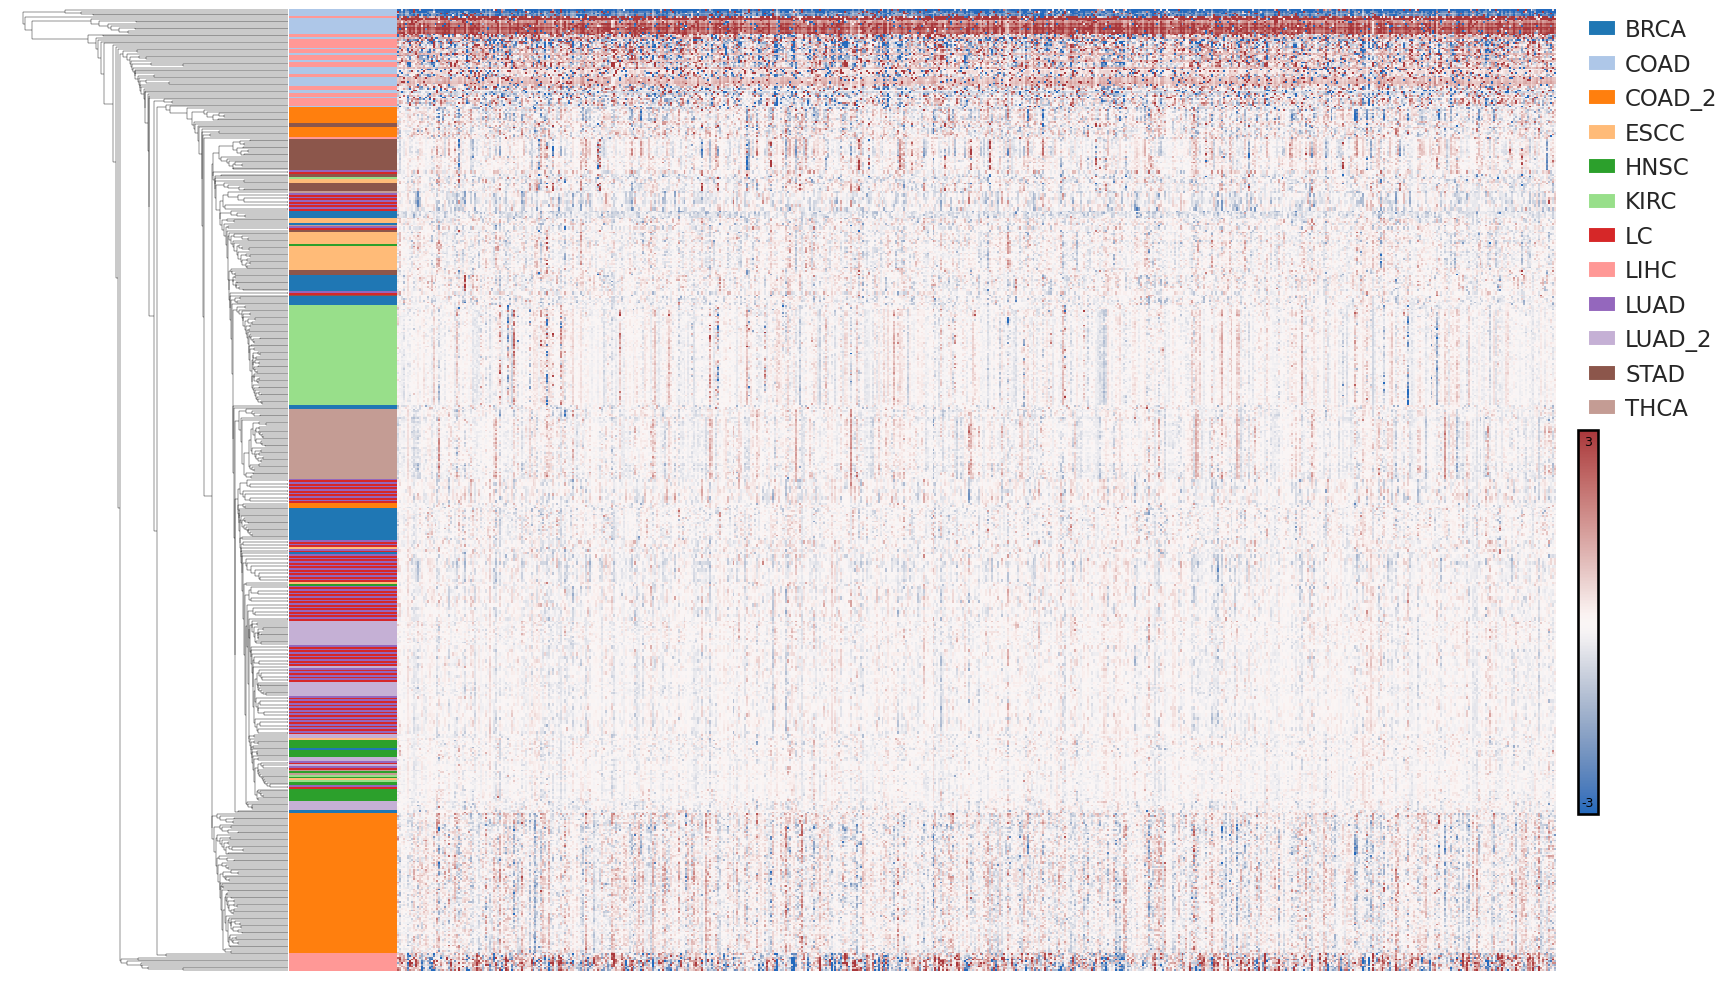

Saved figure to /home/kousis/work/BCProjects/drugs_plots/clustermap_raw_percentile.png


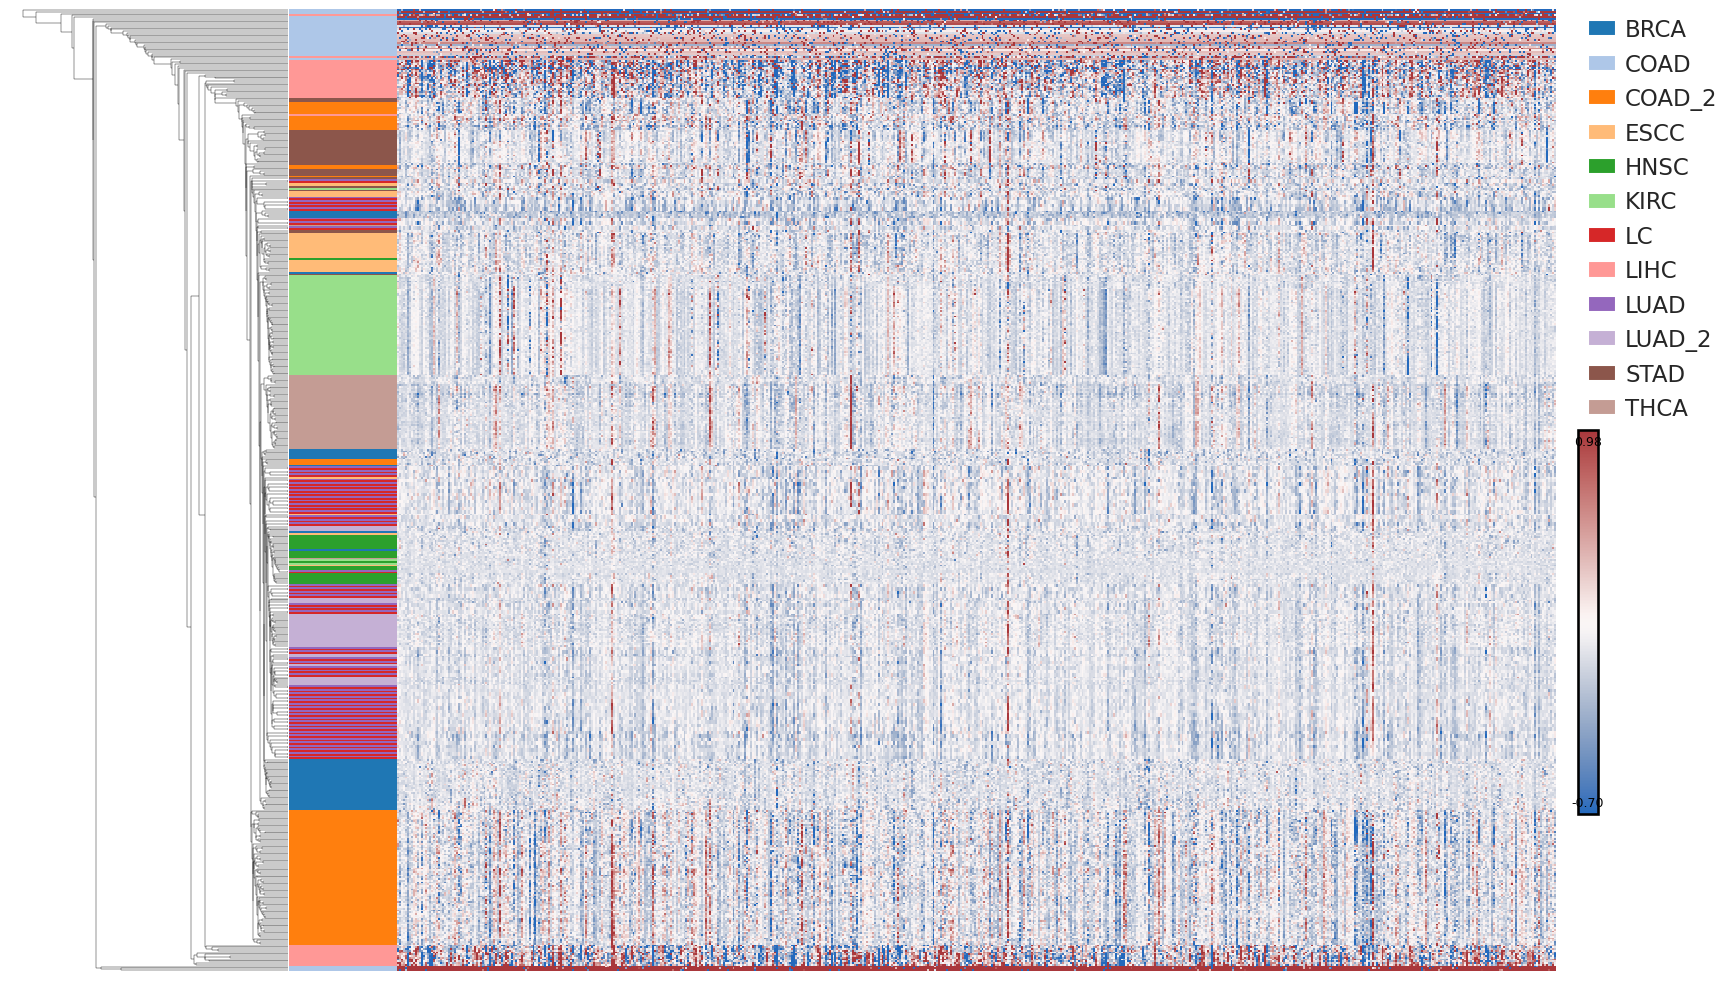

Saved figure to /home/kousis/work/BCProjects/drugs_plots/clustermap_raw_full.png


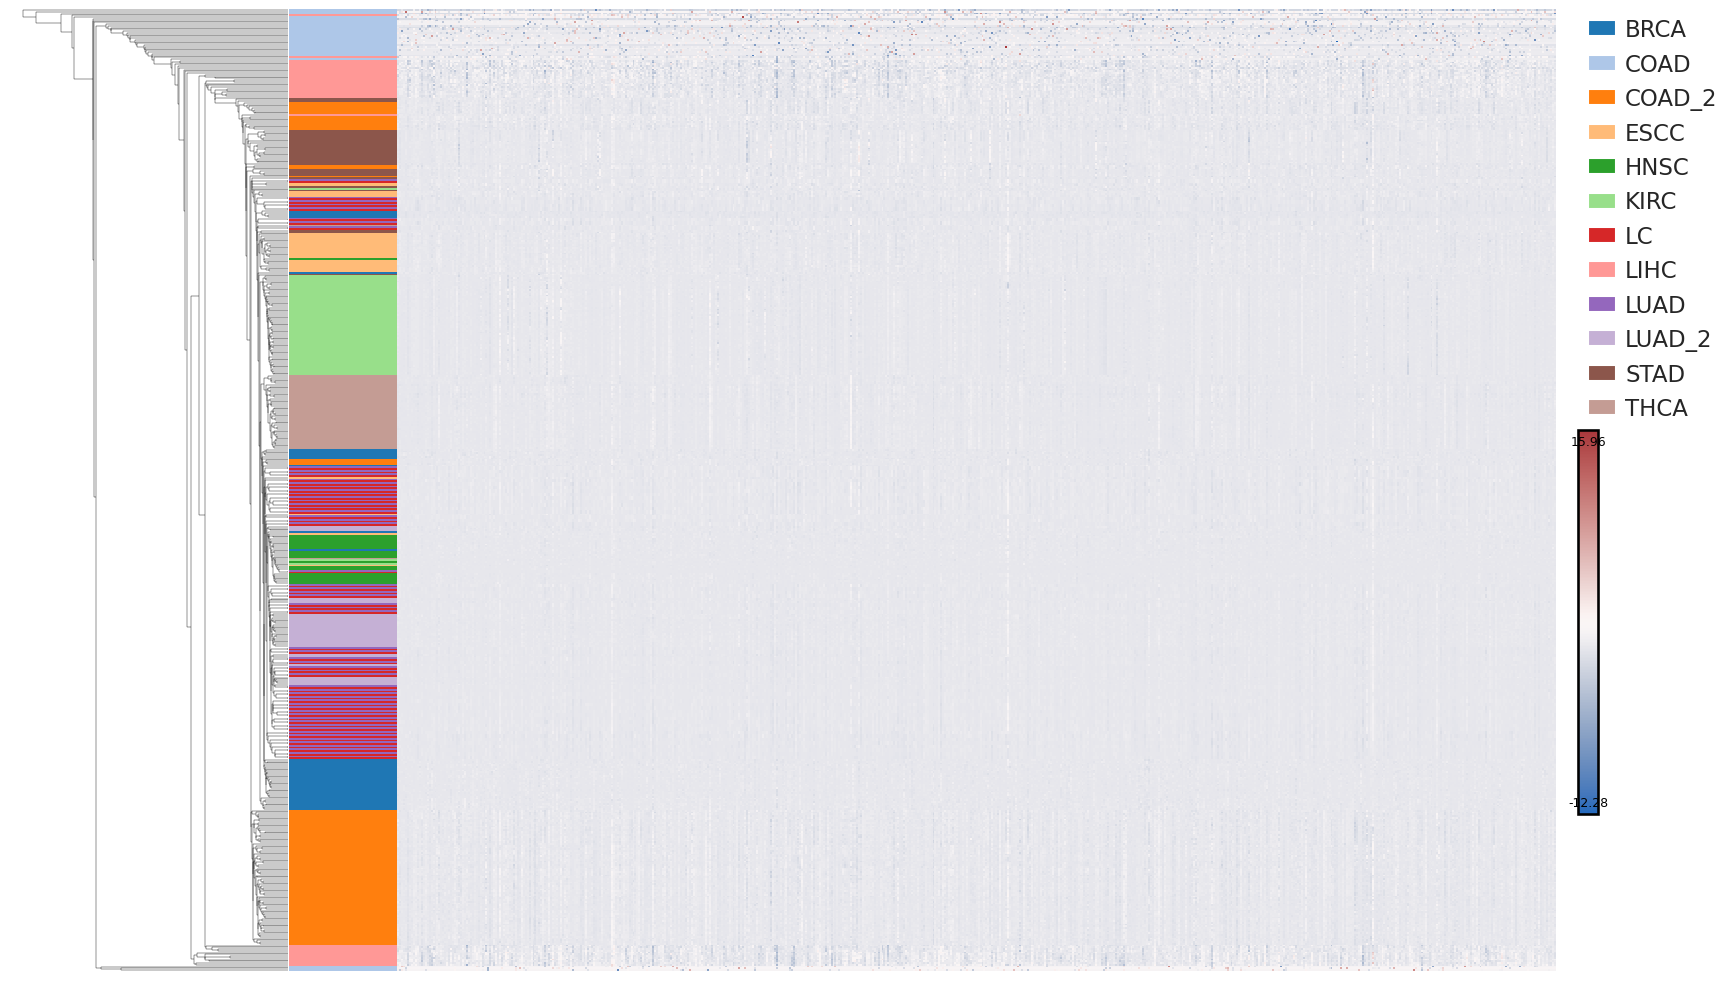

In [116]:
# Plotting 

 # AESTHETICS
sns.set_context("talk")
sns.set_style("white")

FIGSIZE = (16, 11)
DENDRO_RATIO = (0.18, 0.08)   # more room for row dendrogram
COLORS_RATIO = (0.07, 0.06)   # width of the row color strip
TREE_LINEWIDTH = 0.3          # thin dendrogram lines
CBAR_HEIGHT_FRAC = 0.40       # colorbar height vs. heatmap height
CBAR_X_PAD = 0.014            # horizontal gap (fig fraction) to the right of heatmap
CBAR_Y_SHIFT = -0.12          # move bar up (>0) / down (<0) relative to center


assert isinstance(X, pd.DataFrame) and isinstance(y, pd.Series)
assert (X.index == y.index).all(), "X.index and y.index must match and be in the same order."


 # COuLorSS
palette = sns.color_palette("tab20", n_colors=y.nunique())
cancer_color_map = dict(zip(sorted(y.unique()), palette))
row_colors = y.map(cancer_color_map)

# Z-scored per gene (clip for readability)
scaler = StandardScaler(with_mean=True, with_std=True)
X_z = pd.DataFrame(
    np.clip(scaler.fit_transform(X.values), -3, 3),
    index=X.index, columns=X.columns
)

# Raw copies
X_raw = X.copy()
X_raw_robust = X.copy()

# Vertical colorbar function
def add_vertical_cbar_outside(
    g, im, vmin, vmax,
    fmt="{:.2f}", edge_pad=0.03,
    height_frac=CBAR_HEIGHT_FRAC, x_pad=CBAR_X_PAD, y_shift=CBAR_Y_SHIFT
):
    """
    Add a vertical colorbar just to the RIGHT of the heatmap (outside).
    Shows ONLY min/max labels INSIDE the bar.
    """
    bb = g.ax_heatmap.get_position()
    w  = 0.012
    h  = bb.height * height_frac
    x0 = bb.x1 + x_pad
    y0 = bb.y0 + (bb.height - h) / 2 + y_shift

    cax = g.fig.add_axes([x0, y0, w, h])
    cb = g.fig.colorbar(im, cax=cax, orientation="vertical")

    # remove external ticks/labels
    cb.set_ticks([])
    cb.minorticks_off()
    cb.ax.set_yticklabels([])
    cb.ax.tick_params(length=0, labelleft=False, labelright=False)
    cb.outline.set_edgecolor("black")

    # edge labels inside the bar
    cax.text(0.5, edge_pad, fmt.format(vmin),
             ha="center", va="center", transform=cax.transAxes, fontsize=9, color="black")
    cax.text(0.5, 1 - edge_pad, fmt.format(vmax),
             ha="center", va="center", transform=cax.transAxes, fontsize=9, color="black")

def finalize(g, thin_lines=TREE_LINEWIDTH):
    # thin black dendrogram
    for coll in g.ax_row_dendrogram.collections:
        coll.set_color("black")
        coll.set_linewidth(thin_lines)
    g.ax_col_dendrogram.set_visible(False)

    # legend at right
    handles = [Patch(facecolor=cancer_color_map[k], label=str(k)) for k in sorted(cancer_color_map)]
    g.ax_heatmap.legend(
        handles=handles, title=None, loc="upper left",
        bbox_to_anchor=(1.02, 1.0), frameon=False, ncol=1,
        borderaxespad=0.0, handlelength=1.2, handletextpad=0.4
    )

# Figure A: Z-SCORED CLIPPED
vmin_a, vmax_a = -3, 3
row_link_a = linkage(X_z.values, method="average", metric="euclidean")
g = sns.clustermap(
    X_z,
    row_cluster=True, col_cluster=False, row_linkage=row_link_a,
    cmap="vlag", center=0, row_colors=row_colors,
    linewidths=0.0, xticklabels=False, yticklabels=False,
    figsize=FIGSIZE, dendrogram_ratio=DENDRO_RATIO, colors_ratio=COLORS_RATIO,
    cbar_pos=None,  # turn OFF seaborn's colorbar (we add our own)
)
im = g.ax_heatmap.collections[0]
im.set_rasterized(True)
add_vertical_cbar_outside(g, im, vmin_a, vmax_a, fmt="{:.0f}")
finalize(g)
save_fig("clustermap_zscore.png", fig=g.fig)
plt.show()

# Figure B: RAW ROBUST PERCENTILE CLIPPED (RECLUSTER)
vmin_b = float(np.nanpercentile(X_raw_robust.values, 2))
vmax_b = float(np.nanpercentile(X_raw_robust.values, 98))
row_link_b = linkage(X_raw_robust.values, method="average", metric="euclidean")
g2 = sns.clustermap(
    X_raw_robust,
    row_cluster=True, col_cluster=False, row_linkage=row_link_b,
    cmap="vlag", center=None, vmin=vmin_b, vmax=vmax_b, row_colors=row_colors,
    linewidths=0.0, xticklabels=False, yticklabels=False,
    figsize=FIGSIZE, dendrogram_ratio=DENDRO_RATIO, colors_ratio=COLORS_RATIO,
    cbar_pos=None,
)
im2 = g2.ax_heatmap.collections[0]
im2.set_rasterized(True)
add_vertical_cbar_outside(g2, im2, vmin_b, vmax_b, fmt="{:.2f}")
finalize(g2)
save_fig("clustermap_raw_percentile.png", fig=g2.fig)
plt.show()

# Figure C
vmin_c = float(np.nanmin(X_raw.values))
vmax_c = float(np.nanmax(X_raw.values))
row_link_c = linkage(X_raw.values, method="average", metric="euclidean")
g3 = sns.clustermap(
    X_raw,
    row_cluster=True, col_cluster=False, row_linkage=row_link_c,
    cmap="vlag", center=None, vmin=vmin_c, vmax=vmax_c, row_colors=row_colors,
    linewidths=0.0, xticklabels=False, yticklabels=False,
    figsize=FIGSIZE, dendrogram_ratio=DENDRO_RATIO, colors_ratio=COLORS_RATIO,
    cbar_pos=None,
)
im3 = g3.ax_heatmap.collections[0]
im3.set_rasterized(True)
add_vertical_cbar_outside(g3, im3, vmin_c, vmax_c, fmt="{:.2f}")
finalize(g3)
save_fig("clustermap_raw_full.png", fig=g3.fig)
plt.show()


Saved figure to /home/kousis/work/BCProjects/drugs_plots/pca_subset_selected_cancers.png


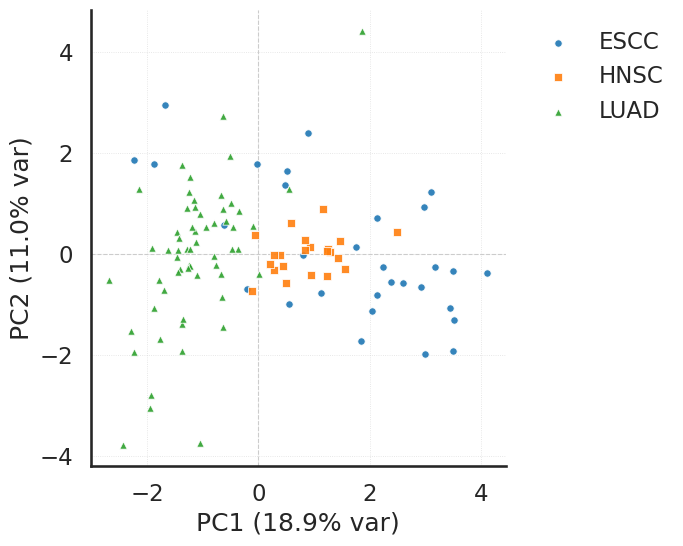

/tmp/ipykernel_385746/2380162104.py:91: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



Saved figure to /home/kousis/work/BCProjects/drugs_plots/clustermap_subset_selected_cancers.png


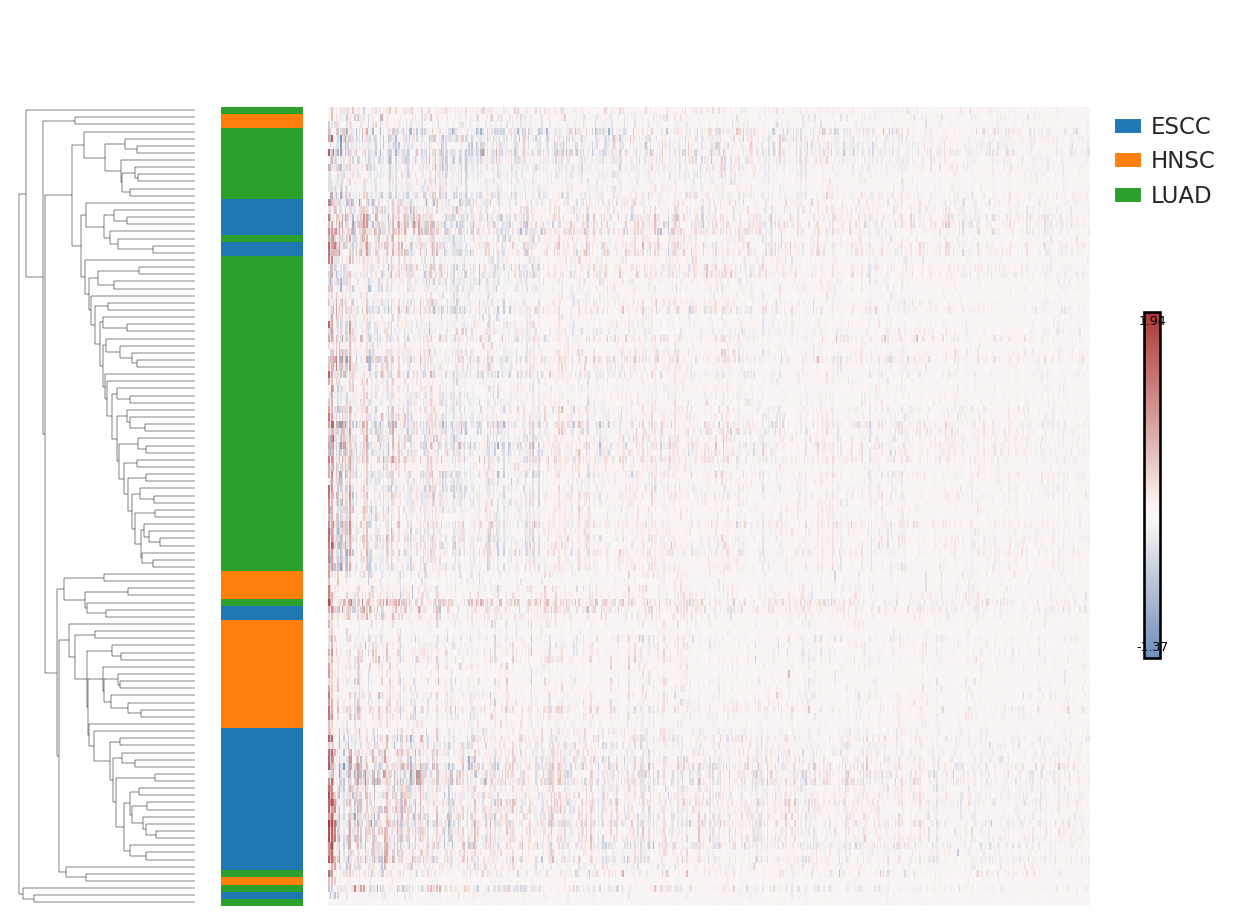

In [117]:
# Subset
keep_types = {"LUAD", "ESCC", "HNSC"}  # set to explore
mask = y.isin(keep_types)
Xsub = X.loc[mask].copy()
ysub = y.loc[mask].copy()
Xsub = Xsub.loc[ysub.index]   
pca = PCA(n_components=2, random_state=0)
Z = pca.fit_transform(Xsub.values)  
evr = pca.explained_variance_ratio_

# Colors
palette = sns.color_palette("tab10", n_colors=ysub.nunique())
cmap_types = dict(zip(sorted(ysub.unique()), palette))
colors = ysub.map(cmap_types)

# PCA
plt.figure(figsize=(7.2, 5.8))
markers = ["o", "s", "^", "D", "P", "X"]
for i, lbl in enumerate(sorted(keep_types)):
    idx = (ysub == lbl).values
    plt.scatter(
        Z[idx, 0], Z[idx, 1],
        s=28, label=lbl, marker=markers[i % len(markers)],
        edgecolors="white", linewidths=0.6, alpha=0.9, zorder=3
    )

plt.axhline(0, color="#cccccc", lw=0.8, ls="--", zorder=1)
plt.axvline(0, color="#cccccc", lw=0.8, ls="--", zorder=1)
plt.grid(True, axis="both", ls=":", lw=0.6, alpha=0.6)
for sp in ["top", "right"]:
    plt.gca().spines[sp].set_visible(False)

plt.xlabel(f"PC1 ({evr[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({evr[1]*100:.1f}% var)")
plt.legend(frameon=False, ncol=1, bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
save_fig("pca_subset_selected_cancers.png")
plt.show()

# Heatmap of raw data subset
# top variable genes (unchanged)
n_top = 500
top_var_genes = Xsub.var(axis=0).sort_values(ascending=False).head(n_top).index
H = Xsub[top_var_genes]  
row_Z = linkage(pdist(H.values,  metric="correlation"), method="average")
col_Z = linkage(pdist(H.values.T, metric="correlation"), method="average")

row_colors = ysub.map(cmap_types)

# layout tweaks
figsize = (13.5, 9.5)
dendrogram_ratio = (0.18, 0.08)   
colors_ratio     = (0.08, 0.06)   
g = sns.clustermap(
    H,
    row_linkage=row_Z, col_linkage=col_Z,
    row_colors=row_colors,
    cmap="vlag",
    center=H.values.mean(),   # visual centering only (still raw data)
    linewidths=0.0,
    xticklabels=False, yticklabels=False,
    figsize=figsize,
    dendrogram_ratio=dendrogram_ratio,
    colors_ratio=colors_ratio,
    cbar_pos=None,
    col_cluster=False
)

for coll in g.ax_row_dendrogram.collections + g.ax_col_dendrogram.collections:
    coll.set_color("black")
    coll.set_linewidth(0.35)

for sp in g.ax_heatmap.spines.values():
    sp.set_linewidth(0.6)
    sp.set_edgecolor("black")

im = g.ax_heatmap.collections[0]
im.set_rasterized(True)
vmin_c = float(np.nanmin(Xsub.values))
vmax_c = float(np.nanmax(Xsub.values))

add_vertical_cbar_outside(g, im, fmt="{:.2f}", height_frac=0.42, y_shift=0.010, vmin=vmin_c, vmax=vmax_c,x_pad=-0.12)

handles = [Patch(facecolor=cmap_types[k], label=str(k)) for k in sorted(cmap_types)]
g.ax_heatmap.legend(
    handles=handles, title=None, frameon=False, ncol=1,
    bbox_to_anchor=(1.02, 1.0), loc="upper left",
    borderaxespad=0.0, handlelength=1.2, handletextpad=0.4
)

g.fig.tight_layout()
g.fig.subplots_adjust(right=0.82)  # space for legend + bar
save_fig("clustermap_subset_selected_cancers.png", fig=g.fig)
plt.show()


### 4.2 Dimensionality Reduction: PCA + UMAP

/home/kousis/miniconda3/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Saved figure to /home/kousis/work/BCProjects/drugs_plots/pca_umap_side_by_side.png


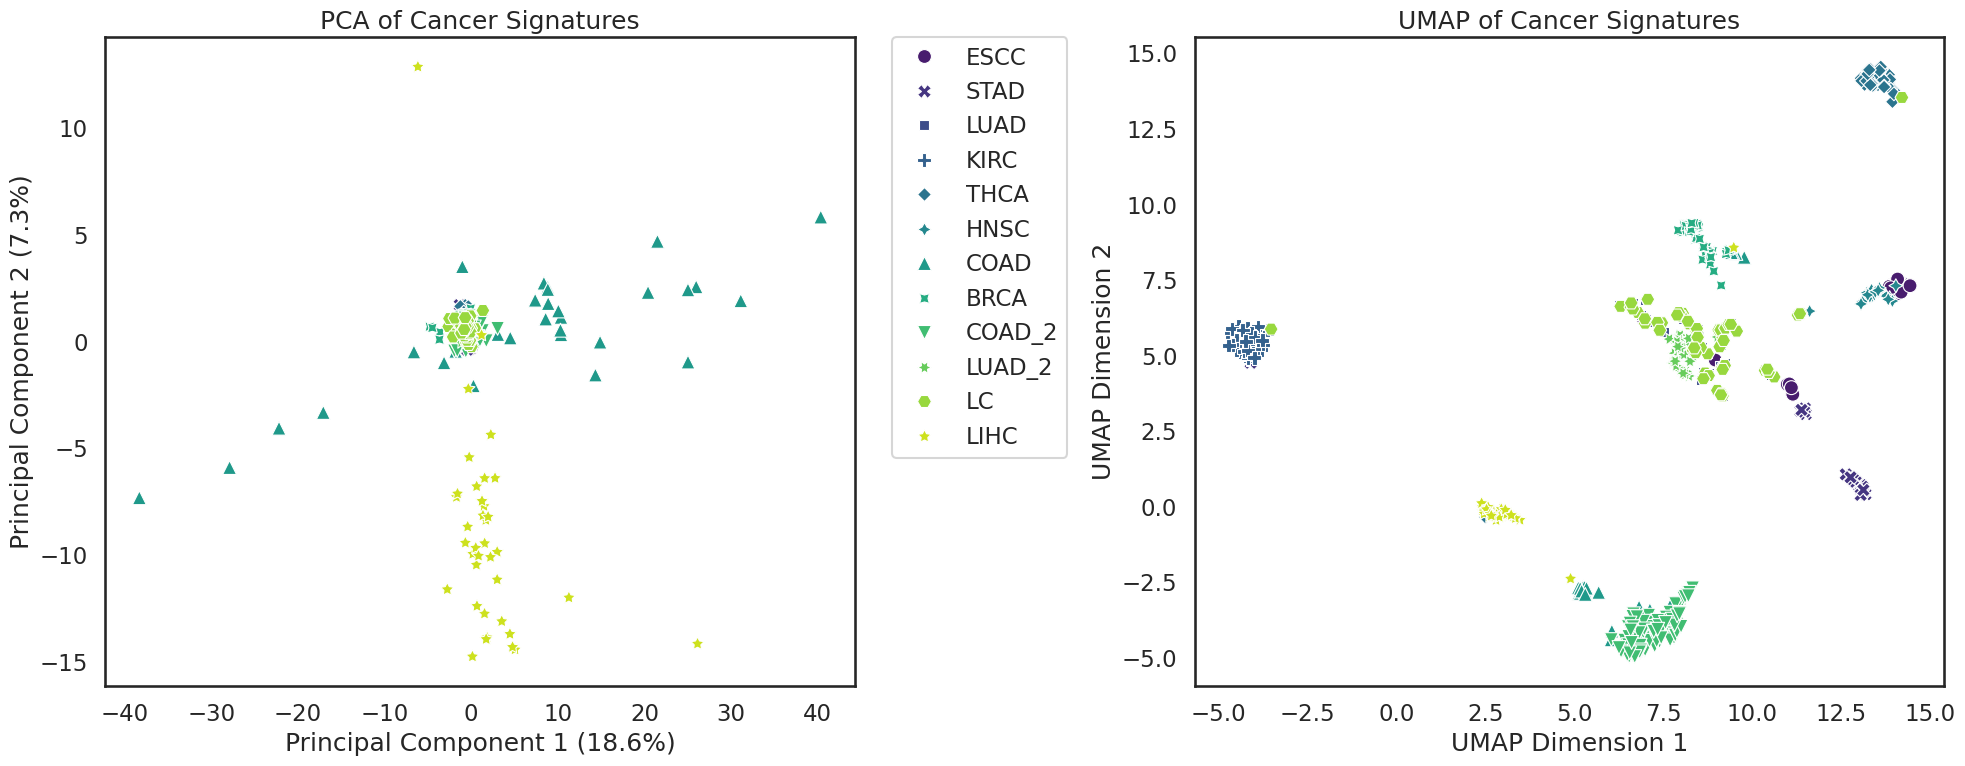

Saved Plotly HTML to /home/kousis/work/BCProjects/drugs_plots/pca_interactive.html
Plotly static export skipped (
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido
)


Saved Plotly HTML to /home/kousis/work/BCProjects/drugs_plots/umap_interactive.html
Plotly static export skipped (
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido
)


In [118]:
# Dimensionality Reduction: PCA + UMAP
y_labels = y.copy()
# PCA
pca = PCA(n_components=2, random_state=77)
pca_coords = pca.fit_transform(X)
evr = pca.explained_variance_ratio_

# UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=77)
umap_coords = reducer.fit_transform(X)

# Create Plotting DataFrame
plot_df = pd.DataFrame({
    'Sample': X.index,
    'CancerType': y_labels.values,
    'PCA1': pca_coords[:, 0],
    'PCA2': pca_coords[:, 1],
    'UMAP1': umap_coords[:, 0],
    'UMAP2': umap_coords[:, 1],
})

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# PCA Plot
sns.scatterplot(data=plot_df, x='PCA1', y='PCA2', hue='CancerType', style='CancerType', s=100, ax=ax1, palette='viridis')
ax1.set_title(f"PCA of Cancer Signatures", fontsize=18)
ax1.set_xlabel(f"Principal Component 1 ({evr[0]:.1%})")
ax1.set_ylabel(f"Principal Component 2 ({evr[1]:.1%})")
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# UMAP Plot
sns.scatterplot(data=plot_df, x='UMAP1', y='UMAP2', hue='CancerType', style='CancerType', s=100, ax=ax2, palette='viridis')
ax2.set_title("UMAP of Cancer Signatures", fontsize=18)
ax2.set_xlabel("UMAP Dimension 1")
ax2.set_ylabel("UMAP Dimension 2")
ax2.get_legend().remove() # Remove duplicate legend
plt.tight_layout()
save_fig("pca_umap_side_by_side.png", fig=fig)
plt.show()

# Interactive Plotly Version 
fig_pca = px.scatter(plot_df, x='PCA1', y='PCA2', color='CancerType', symbol='CancerType',
                         hover_name='Sample', title='Interactive PCA of Cancer Signatures')
save_plotly(fig_pca, "pca_interactive.html", image_filename="pca_interactive.png")
fig_pca.show()
    
fig_umap = px.scatter(plot_df, x='UMAP1', y='UMAP2', color='CancerType', symbol='CancerType',
                          hover_name='Sample', title='Interactive UMAP of Cancer Signatures')
save_plotly(fig_umap, "umap_interactive.html", image_filename="umap_interactive.png")
fig_umap.show()

In [119]:
y = y.replace({
     "LC": "LUAD", "HCC": "LIHC", "LUAD_2": "LUAD","COAD_2": "COAD"
    })
y_labels = y
# Ensure y is a Series
y_series = y_labels if isinstance(y_labels, pd.Series) else pd.Series(y_labels, index=X_T.index)

# Align to X_T.index (the sample order used in X_scaled / plot_df)
y_true = y_series.reindex(X.index)

# Optional sanity checks
print("X shape:", X.shape)
print("len(y_true):", len(y_true))
assert X.shape[0] == len(y_true), "X and y must have the same number of samples after alignment."
assert y_true.isna().sum() == 0, "Found NaNs in y after reindexing; ensure all X_T samples have labels."


X shape: (549, 591)
len(y_true): 549


Saved figure to /home/kousis/work/BCProjects/drugs_plots/pca_gene_loadings.png


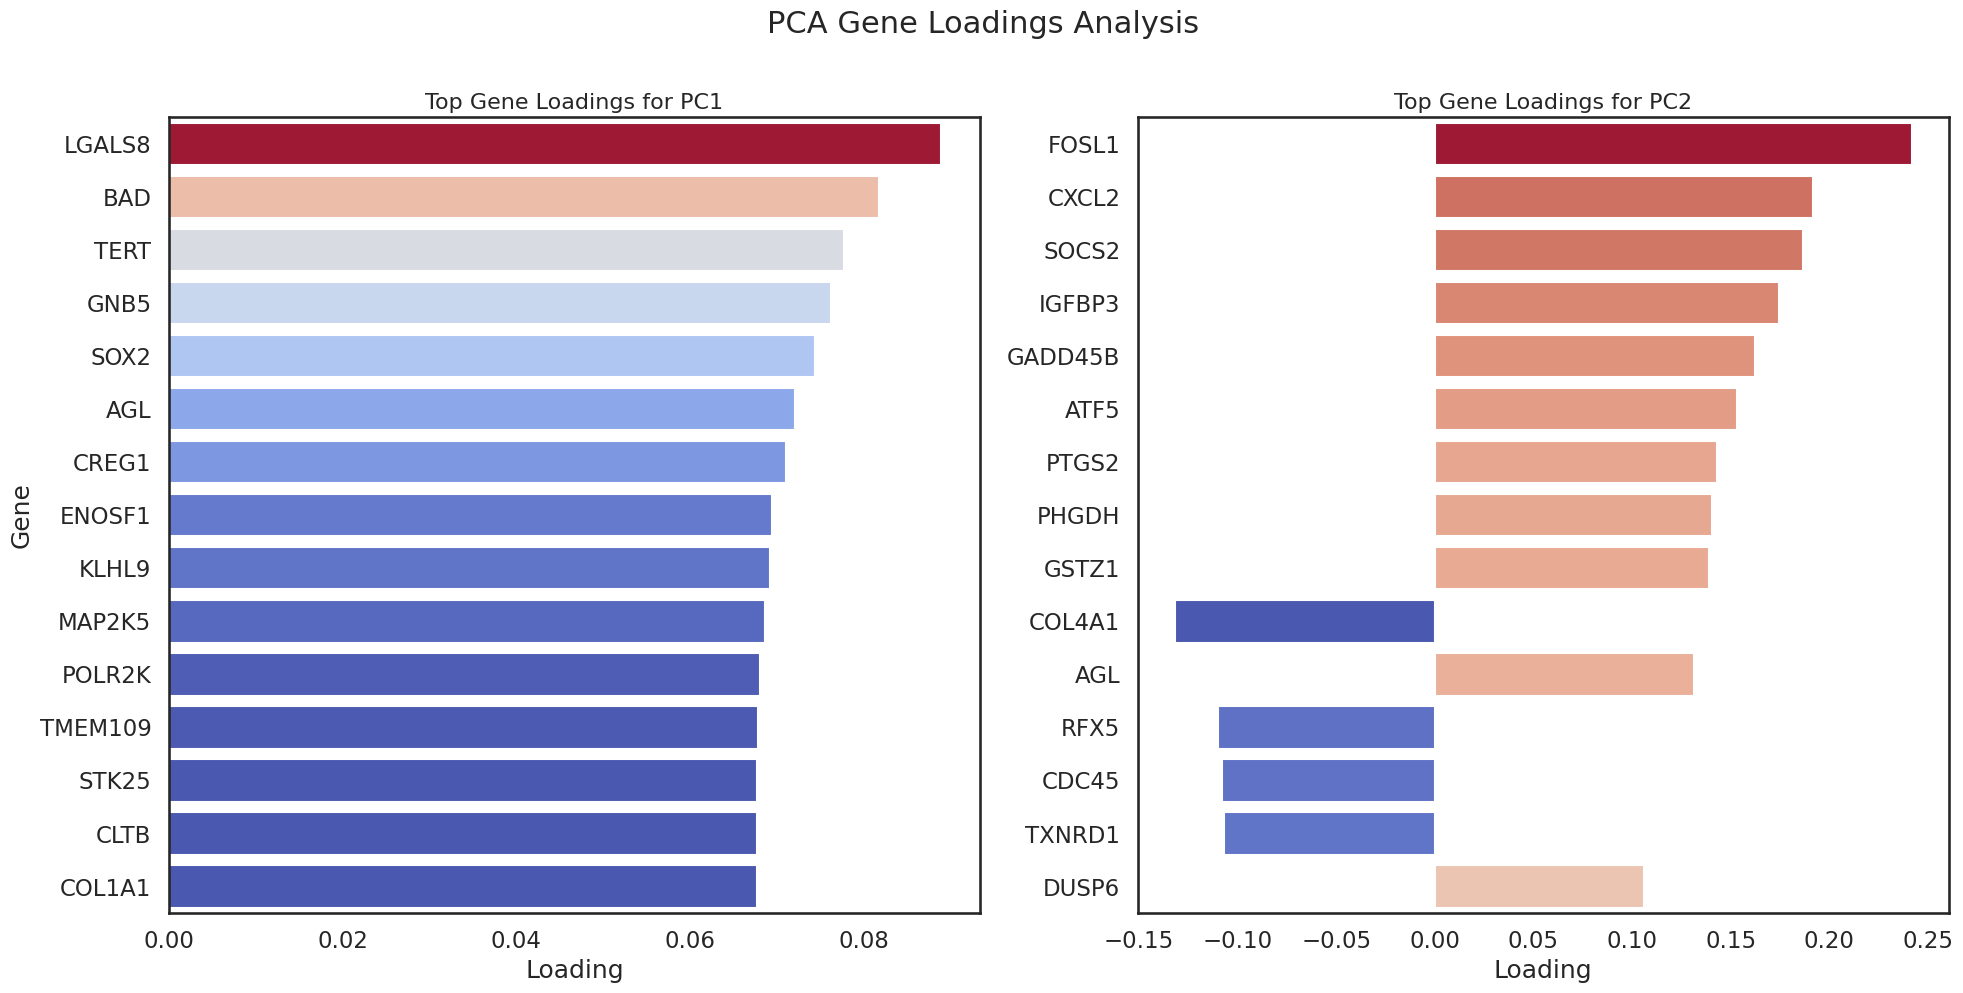

In [120]:
# PCA Loadings Analysis
n_features = pca.components_.shape[1]  # columns in PCA fit

def _get_feature_index():
    # Prefer X columns if they exist and match n_features
    if isinstance(X, pd.DataFrame) and len(X.columns) == n_features:
        return X.columns

    # Fall back to X if it's a DataFrame with the right number of columns
    if 'X' in globals() and isinstance(X, pd.DataFrame) and len(X.columns) == n_features:
        return X.columns

    # Last resort: synthesize generic feature names
    return pd.Index([f"Feature_{i}" for i in range(n_features)])

feature_index = _get_feature_index()

# PCA Loadings DataFrame
# loadings shape: (n_features, n_components)
loadings = pca.components_.T 

 # Guard in case n_components != 2 (future-proofing)
n_components_used = min(2, pca.components_.shape[0])
cols = [f"PC{i+1}" for i in range(n_components_used)]

loadings_df = pd.DataFrame(loadings[:, :n_components_used], columns=cols, index=feature_index)

# absolute columns for ranking
for c in cols:
    loadings_df[f"Abs_{c}"] = loadings_df[c].abs()

# Top 15 by absolute loading per PC
tops = {}
for c in cols:
    tops[c] = loadings_df.sort_values(f"Abs_{c}", ascending=False).head(15)

# Plotting top loadings
n_plots = len(cols)
fig, axes = plt.subplots(1, n_plots, figsize=(10*n_plots, 10))

# Normalize axes to an iterable
if n_plots == 1:
    axes = [axes]

for ax, c in zip(axes, cols):
    sns.barplot(x=tops[c][c], y=tops[c].index, ax=ax, palette='coolwarm',hue=tops[c][c],legend=False)
    ax.set_title(f'Top Gene Loadings for {c}', fontsize=16)
    ax.set_xlabel('Loading')
    ax.set_ylabel('Gene' if c == 'PC1' else '')


plt.suptitle('PCA Gene Loadings Analysis', fontsize=22, y=1.0)
plt.tight_layout()
save_fig("pca_gene_loadings.png", fig=fig)
plt.show()

top_pc_tables = {c: tops[c][[c, f"Abs_{c}"]] for c in cols}


Saved figure to /home/kousis/work/BCProjects/drugs_plots/umap_feature_correlations.png


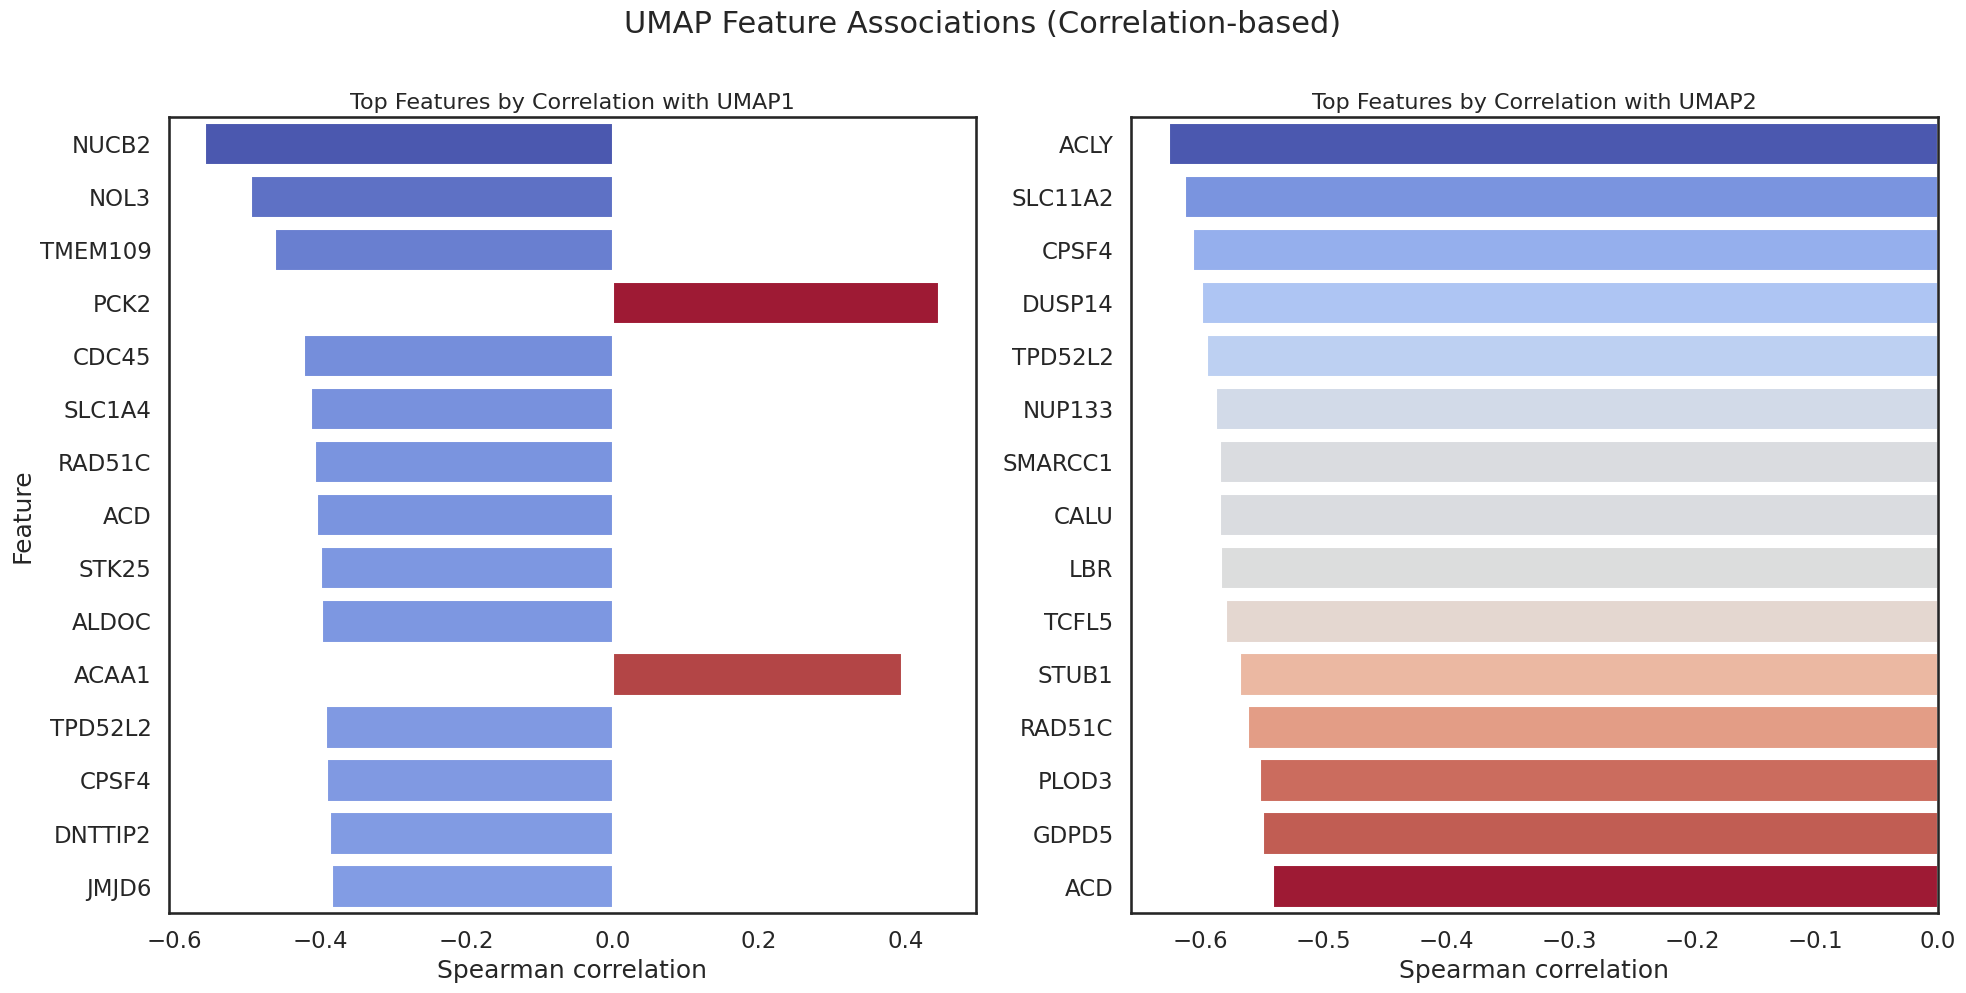

In [121]:
# UMAP Feature Association Analysis
X_pd = pd.DataFrame(X, index=X.index)

# Correlations with UMAP dimensions
umap_df = plot_df.set_index('Sample')[['UMAP1','UMAP2']]

corr_umap1 = X_pd.corrwith(umap_df['UMAP1'], method='spearman')
corr_umap2 = X_pd.corrwith(umap_df['UMAP2'], method='spearman')

corr_df = pd.DataFrame({
    'Spearman_UMAP1': corr_umap1,
    'Spearman_UMAP2': corr_umap2,
    'Abs_UMAP1': corr_umap1.abs(),
    'Abs_UMAP2': corr_umap2.abs(),
}).sort_values('Abs_UMAP1', ascending=False)

# Top features per axis
top_umap1 = corr_df.sort_values('Abs_UMAP1', ascending=False).head(15)
top_umap2 = corr_df.sort_values('Abs_UMAP2', ascending=False).head(15)

# Plotting top correlated features
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
sns.barplot(x=top_umap1['Spearman_UMAP1'], y=top_umap1.index, ax=ax1, palette='coolwarm',hue=top_umap1['Spearman_UMAP1'],legend=False)
ax1.set_title('Top Features by Correlation with UMAP1', fontsize=16)
ax1.set_xlabel('Spearman correlation')
ax1.set_ylabel('Feature')

sns.barplot(x=top_umap2['Spearman_UMAP2'], y=top_umap2.index, ax=ax2, palette='coolwarm',hue=top_umap2['Spearman_UMAP2'],legend=False)
ax2.set_title('Top Features by Correlation with UMAP2', fontsize=16)
ax2.set_xlabel('Spearman correlation')
ax2.set_ylabel('')

plt.suptitle('UMAP Feature Associations (Correlation-based)', fontsize=22, y=1.0)
plt.tight_layout()
save_fig("umap_feature_correlations.png", fig=fig)
plt.show()

# (Optional) tables to inspect
top_umap1_tbl = top_umap1[['Spearman_UMAP1','Abs_UMAP1']]
top_umap2_tbl = top_umap2[['Spearman_UMAP2','Abs_UMAP2']]


### 4.3 Kmeans Analysis

In [122]:
# Custom KMeans to allow Manhattan distance 
def kmeans_manual(data, n_clusters=4, distance='euclidean', init='kmeans++',
                  max_iter=100, tol=1e-4, random_state=42):
    # Ensure array (handles pandas DataFrame gracefully)
    X = np.asarray(data, dtype=float)
    rng = np.random.RandomState(random_state)
    n_samples, n_features = X.shape

    # Init
    if init == 'random':
        idx = rng.choice(n_samples, n_clusters, replace=False)
        centroids = X[idx].astype(float)
    elif init == 'kmeans++':
        centroids = np.zeros((n_clusters, n_features), dtype=float)
        centroids[0] = X[rng.choice(n_samples)]
        for i in range(1, n_clusters):
            dist_sq = np.min(cdist(X, centroids[:i], 'sqeuclidean'), axis=1)
            s = dist_sq.sum()
            if s == 0:  # all identical; pick uniformly
                probs = np.full(n_samples, 1.0 / n_samples)
            else:
                probs = dist_sq / s
            centroids[i] = X[rng.choice(n_samples, p=probs)]
    else:
        raise ValueError("init must be 'random' or 'kmeans++'")

    # Lloyd iterations
    for _ in range(max_iter):
        D = cdist(X, centroids, 'cityblock' if distance == 'manhattan' else 'euclidean')
        labels = np.argmin(D, axis=1)

        new_centroids = []
        for k in range(n_clusters):
            mask = (labels == k)
            if np.any(mask):
                new_centroids.append(X[mask].mean(axis=0))
            else:
                new_centroids.append(X[rng.choice(n_samples)])
        new_centroids = np.vstack(new_centroids)

        if np.linalg.norm(new_centroids - centroids) < tol:
            break
        centroids = new_centroids

    return centroids, labels

# Setup
n_clusters = int(len(pd.unique(y_labels)))
clustering_results = []

# Algorithms
algorithms = {
    "KMeans (Euclidean, k-means++)": KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=42),
    "Hierarchical (Ward)": AgglomerativeClustering(n_clusters=n_clusters, linkage='ward'),
}

print("--- Running Clustering Algorithms ---")
for name, model in algorithms.items():
    print(f"Fitting {name}...")
    # Agglomerative doesn't support predict; use fit_predict for all for uniformity
    labels_pred = model.fit_predict(X_pd)
    ari = adjusted_rand_score(y_labels, labels_pred)

    # Silhouette requires at least 2 clusters and not all singleton
    try:
        sil = silhouette_score(X_pd, labels_pred)
    except Exception:
        sil = np.nan

    clustering_results.append({'Algorithm': name, 'ARI': ari, 'Silhouette': sil, 'Labels': labels_pred})

# Custom Manhattan KMeans
print("Fitting KMeans (Manhattan, k-means++)...")
_, manhattan_labels = kmeans_manual(X_pd, n_clusters=n_clusters, distance='manhattan',
                                    init='kmeans++', random_state=42)
ari_manhattan = adjusted_rand_score(y_labels, manhattan_labels)
try:
    sil_manhattan = silhouette_score(X_pd, manhattan_labels, metric='manhattan')
except Exception:
    sil_manhattan = np.nan

clustering_results.append({
    'Algorithm': 'KMeans (Manhattan, k-means++)',
    'ARI': ari_manhattan,
    'Silhouette': sil_manhattan,
    'Labels': manhattan_labels
})

# Results DataFrame 
results_df = pd.DataFrame(clustering_results)
print("\n--- Clustering Performance ---")
print(results_df[['Algorithm', 'ARI', 'Silhouette']].sort_values('ARI', ascending=False))


--- Running Clustering Algorithms ---
Fitting KMeans (Euclidean, k-means++)...
Fitting Hierarchical (Ward)...
Fitting KMeans (Manhattan, k-means++)...
Fitting Hierarchical (Ward)...
Fitting KMeans (Manhattan, k-means++)...

--- Clustering Performance ---
                       Algorithm       ARI  Silhouette
2  KMeans (Manhattan, k-means++)  0.427799    0.045516
0  KMeans (Euclidean, k-means++)  0.201306    0.291481
1            Hierarchical (Ward)  0.180033    0.208302

--- Clustering Performance ---
                       Algorithm       ARI  Silhouette
2  KMeans (Manhattan, k-means++)  0.427799    0.045516
0  KMeans (Euclidean, k-means++)  0.201306    0.291481
1            Hierarchical (Ward)  0.180033    0.208302


Saved figure to /home/kousis/work/BCProjects/drugs_plots/clustering_performance_scores.png


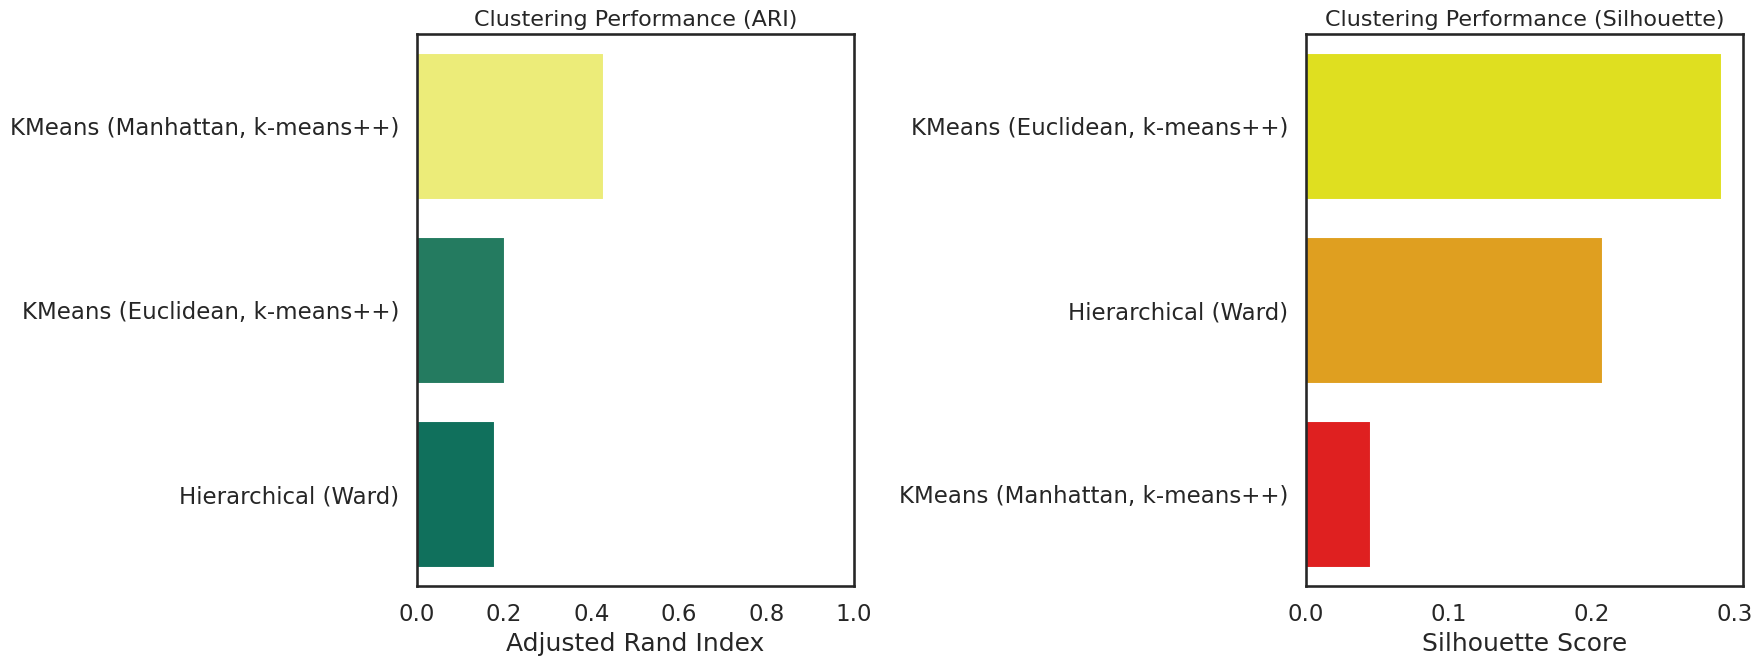

In [123]:
# --- Bar Plots of ARI and Silhouette ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

results_df_sorted_ari = results_df.sort_values('ARI', ascending=False)
results_df_sorted_sil = results_df.sort_values('Silhouette', ascending=False)

sns.barplot(data=results_df_sorted_ari, x='ARI', y='Algorithm', ax=ax1, palette='summer', hue='ARI', legend=False)
ax1.set_title('Clustering Performance (ARI)', fontsize=16)
ax1.set_xlabel('Adjusted Rand Index')
ax1.set_ylabel('')
ax1.set_xlim(0, 1.0)

sns.barplot(data=results_df_sorted_sil, x='Silhouette', y='Algorithm', ax=ax2, palette='autumn', hue='Silhouette', legend=False)
ax2.set_title('Clustering Performance (Silhouette)', fontsize=16)
ax2.set_xlabel('Silhouette Score')
ax2.set_ylabel('')

plt.tight_layout()
save_fig("clustering_performance_scores.png", fig=fig)
plt.show()


## 5. Supervised Learning & Pathway Enrichment
Perform Random Forest with nested cross-validation for accurate performance estimation. Assess important features and analyze implicated gene pathways.


In [124]:
# Supervised Learning Preparation
# Reload data without imputation, using landmark genes only, to ensure no data leakage
X, y, feature_order = load_and_combine_signatures(
    target_genes=landmarks,
    max_nan_frac=1.0,     
    impute=False, # Do TOuch 
    datasets_map=datasets
)
y = y.replace({
     "LC": "LUAD", "HCC": "LIHC", "LUAD_2": "LUAD","COAD_2": "COAD"
    })


# Per-class counts 
print("Counts:\n", y.value_counts().sort_index())


INFO: Loaded GSE38129: 30 samples × 787 genes (dropped 0 all-NaN genes, 0 all-NaN samples).
INFO: Loaded GSE65801: 32 samples × 796 genes (dropped 0 all-NaN genes, 0 all-NaN samples).
INFO: Loaded GSE19804: 60 samples × 787 genes (dropped 0 all-NaN genes, 0 all-NaN samples).
INFO: Loaded GSE53757: 60 samples × 787 genes (dropped 0 all-NaN genes, 0 all-NaN samples).
INFO: Loaded GSE33630: 44 samples × 787 genes (dropped 0 all-NaN genes, 0 all-NaN samples).
INFO: Loaded GSE6631: 22 samples × 672 genes (dropped 0 all-NaN genes, 0 all-NaN samples).
INFO: Loaded GSE74602: 30 samples × 784 genes (dropped 0 all-NaN genes, 0 all-NaN samples).
INFO: Loaded GSE15852: 43 samples × 787 genes (dropped 0 all-NaN genes, 0 all-NaN samples).
INFO: Loaded GSE44076: 98 samples × 795 genes (dropped 0 all-NaN genes, 0 all-NaN samples).
INFO: Loaded GSE10072: 33 samples × 787 genes (dropped 0 all-NaN genes, 0 all-NaN samples).
INFO: Loaded GSE33356: 60 samples × 787 genes (dropped 0 all-NaN genes, 61 all-Na

In [125]:
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import balanced_accuracy_score

# Per fold feature dropper
class DropMissingByFrac(BaseEstimator, TransformerMixin):
    """
    Drops columns whose NaN fraction in the training data exceeds `threshold`.
    Stores a boolean mask of kept columns and applies the same selection to test.
    """
    def __init__(self, threshold=0.05):
        self.threshold = threshold
        self.keep_mask_ = None
        self.feature_names_in_ = None

    def fit(self, X, y=None):
        X_df = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X)
        self.feature_names_in_ = X_df.columns
        nan_frac = X_df.isna().mean(axis=0)
        keep = nan_frac <= self.threshold
        # if extreme case (all bad), keep the least-bad column
        if not keep.any():
            keep.iloc[nan_frac.idxmin()] = True
        self.keep_mask_ = keep
        return self

    def transform(self, X):
        X_df = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X, columns=self.feature_names_in_)
        return X_df.loc[:, self.keep_mask_.values]

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = self.feature_names_in_
        return np.asarray(input_features)[self.keep_mask_.values]

#  Prep X, y (allow NaNs; pipeline will handle them) 
X_df = X.copy() if isinstance(X, pd.DataFrame) else pd.DataFrame(X, columns=feature_order)
y_series = y if isinstance(y, pd.Series) else pd.Series(y, index=X_df.index)

le = LabelEncoder()
y_encoded = le.fit_transform(y_series)

# Pipeline (per-fold filtering + per-fold imputation + RF)
pipeline = Pipeline(steps=[
    ('drop_nan_by_frac', DropMissingByFrac(threshold=0.05)),# per-fold feature selection
    ('imputer', SimpleImputer(strategy='mean', keep_empty_features=False)),# per-fold imputation
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)),
])

param_grid = {
    'classifier__n_estimators': [100, 200, 400, 600],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5, 10],
}

# Nested CV
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=43)

nested_scores = []
all_y_true, all_y_pred = [], []

print("--- Starting Nested Cross-Validation for Model Evaluation ---")
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X_df, y_encoded)):
    print(f"Outer Fold {i+1}/5...")
    X_train, X_test = X_df.iloc[train_idx], X_df.iloc[test_idx]
    y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]

    clf = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=inner_cv,
        scoring='balanced_accuracy',
        n_jobs=-1
    )
    clf.fit(X_train, y_train)

    best_model = clf.best_estimator_
    y_pred = best_model.predict(X_test)
    score = balanced_accuracy_score(y_test, y_pred)
    nested_scores.append(score)
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)
    print(f"  Fold Balanced Acc: {score:.4f}")

print("\n--- Nested CV Complete ---")
print(f"Average Balanced Acc: {np.mean(nested_scores):.4f} ± {np.std(nested_scores):.4f}")

# --------- Final model on full data (same in-pipeline preprocessing) ---------
print("\n--- Training Final Model on Entire Dataset ---")
final_clf = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=inner_cv,
    scoring='balanced_accuracy',
    n_jobs=-1
)
final_clf.fit(X_df, y_encoded)
final_model = final_clf.best_estimator_

print(f"Best hyperparameters for final model: {final_clf.best_params_}")

--- Starting Nested Cross-Validation for Model Evaluation ---
Outer Fold 1/5...
  Fold Balanced Acc: 0.9310
Outer Fold 2/5...
  Fold Balanced Acc: 0.9310
Outer Fold 2/5...
  Fold Balanced Acc: 0.9590
Outer Fold 3/5...
  Fold Balanced Acc: 0.9590
Outer Fold 3/5...
  Fold Balanced Acc: 0.8981
Outer Fold 4/5...
  Fold Balanced Acc: 0.8981
Outer Fold 4/5...
  Fold Balanced Acc: 0.9444
Outer Fold 5/5...
  Fold Balanced Acc: 0.9444
Outer Fold 5/5...
  Fold Balanced Acc: 0.9029

--- Nested CV Complete ---
Average Balanced Acc: 0.9271 ± 0.0235

--- Training Final Model on Entire Dataset ---
  Fold Balanced Acc: 0.9029

--- Nested CV Complete ---
Average Balanced Acc: 0.9271 ± 0.0235

--- Training Final Model on Entire Dataset ---
Best hyperparameters for final model: {'classifier__max_depth': 10, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 600}
Best hyperparameters for final model: {'classifier__max_depth': 10, 'classifier__min_samples_split': 10, 'classifier__n_estimators

Saved figure to /home/kousis/work/BCProjects/drugs_plots/confusion_matrices.png


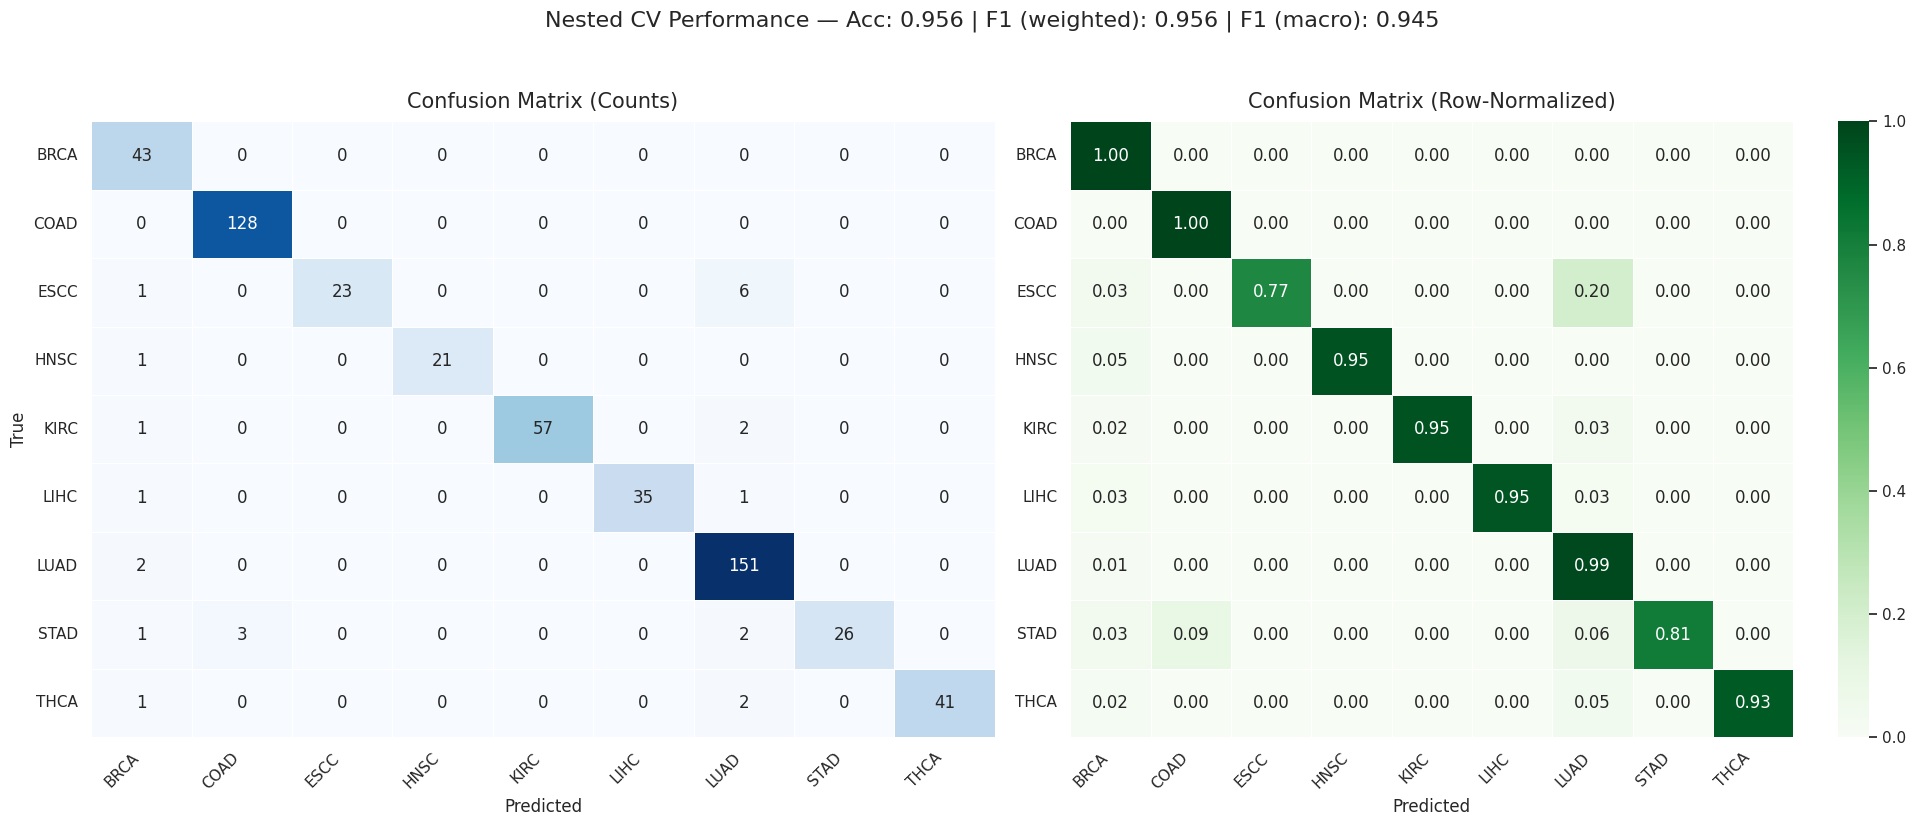

Overall summary:
              Precision  Recall    F1  Support
accuracy          0.956   0.956 0.956    0.956
macro avg         0.971   0.928 0.945  549.000
weighted avg      0.960   0.956 0.956  549.000
Saved figure to /home/kousis/work/BCProjects/drugs_plots/per_class_f1_scores.png
Saved figure to /home/kousis/work/BCProjects/drugs_plots/per_class_f1_scores.png


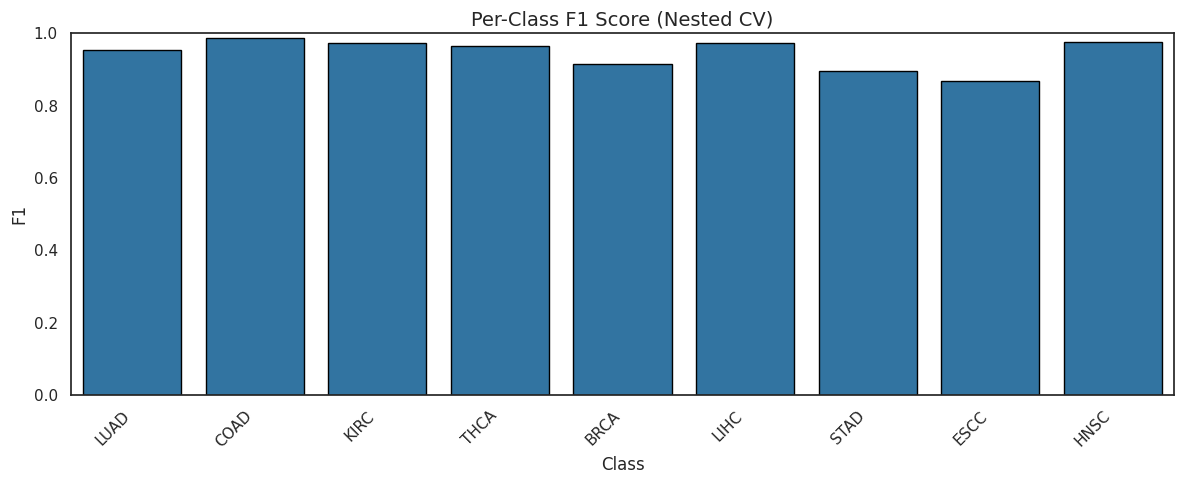

In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

report_dict = classification_report(all_y_true, all_y_pred, target_names=le.classes_, output_dict=True)
report_df = (pd.DataFrame(report_dict).T
             .rename(columns={'precision':'Precision', 'recall':'Recall', 'f1-score':'F1', 'support':'Support'}))

overall_rows = report_df.loc[report_df.index.isin(['accuracy', 'macro avg', 'weighted avg'])].copy()
class_rows = report_df.loc[~report_df.index.isin(['accuracy', 'macro avg', 'weighted avg'])].copy()

# Make class names a column & sort (choose 'Support' or 'F1')
class_rows = class_rows.reset_index().rename(columns={'index':'Class'})
class_rows_sorted = class_rows.sort_values(by=['Support','F1'], ascending=[False, False])

# Confusion Matrix
labels = le.classes_
cm = confusion_matrix(all_y_true, all_y_pred, labels=range(len(labels)))
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
cm_norm = np.nan_to_num(cm_norm)  # guard any div-by-zero

# Global metrics for title
acc = accuracy_score(all_y_true, all_y_pred)
f1w = f1_score(all_y_true, all_y_pred, average='weighted')
f1m = f1_score(all_y_true, all_y_pred, average='macro')

# Plot heatmaps
sns.set_context("notebook")
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=labels, yticklabels=labels, linewidths=.5, linecolor='white', ax=axes[0])
axes[0].set_title('Confusion Matrix (Counts)', fontsize=15, pad=10)
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_ylabel('True', fontsize=12)
plt.setp(axes[0].get_xticklabels(), rotation=45, ha='right')
plt.setp(axes[0].get_yticklabels(), rotation=0, va='center')

# Row-normalized
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Greens', vmin=0, vmax=1, cbar=True,
            xticklabels=labels, yticklabels=labels, linewidths=.5, linecolor='white', ax=axes[1])
axes[1].set_title('Confusion Matrix (Row-Normalized)', fontsize=15, pad=10)
axes[1].set_xlabel('Predicted', fontsize=12)
axes[1].set_ylabel('')
plt.setp(axes[1].get_xticklabels(), rotation=45, ha='right')
plt.setp(axes[1].get_yticklabels(), rotation=0, va='center')


plt.suptitle(f'Nested CV Performance — Acc: {acc:.3f} | F1 (weighted): {f1w:.3f} | F1 (macro): {f1m:.3f}',
             fontsize=16, y=1.03)
plt.tight_layout()
save_fig("confusion_matrices.png", fig=fig)
plt.show()

display_cols = ['Class', 'Precision', 'Recall', 'F1', 'Support']
styled = (class_rows_sorted[display_cols]
          .style.format({'Precision':'{:.3f}','Recall':'{:.3f}','F1':'{:.3f}','Support':'{:.0f}'})
          .background_gradient(subset=['Precision','Recall','F1'], cmap='YlGn')
          .set_properties(**{'text-align': 'left'})
          .set_table_styles([dict(selector='th', props=[('text-align', 'left')])]))
display(styled)

print("Overall summary:")
print(overall_rows[['Precision','Recall','F1','Support']].to_string(float_format=lambda x: f"{x:.3f}"))
plt.figure(figsize=(12, 5))
sns.barplot(data=class_rows_sorted, x='Class', y='F1', edgecolor='black')
plt.title('Per-Class F1 Score (Nested CV)', fontsize=14)
plt.ylabel('F1')
plt.ylim(0, 1.0)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
save_fig("per_class_f1_scores.png")
plt.show()


Saved figure to /home/kousis/work/BCProjects/drugs_plots/nested_cv_balanced_accuracy.png


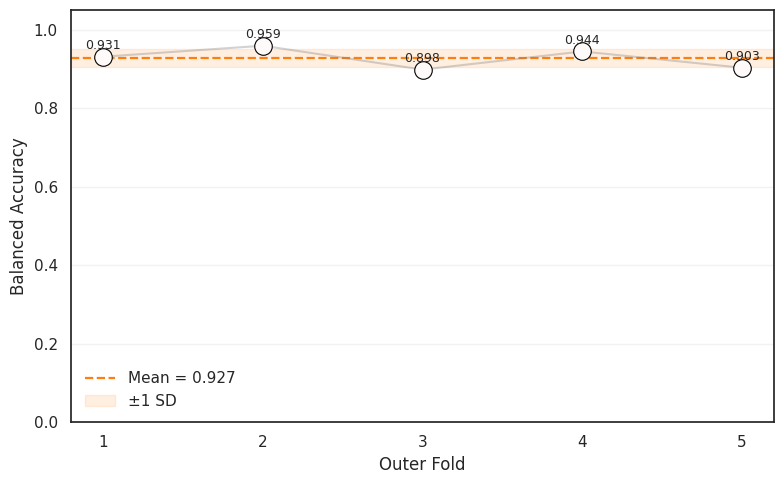

In [127]:
import numpy as np
import matplotlib.pyplot as plt

scores = np.asarray(nested_scores, dtype=float)
mean_ = scores.mean()
std_  = scores.std(ddof=0)
x = np.arange(1, len(scores) + 1)

plt.figure(figsize=(8, 5))

# neutral scatter 
plt.scatter(
    x, scores,
    s=160, marker="o",
    facecolors="snow", edgecolors="black", linewidth=0.8, zorder=3
)

# subtle guide line (neutral)
plt.plot(x, scores, color="0.5", alpha=0.35, linewidth=1.5, zorder=2)

# mean line (colored)
plt.axhline(mean_, color="tab:orange", linestyle="--", linewidth=1.6,
            label=f"Mean = {mean_:.3f}", zorder=1)

# ±1 SD band (colored)
plt.axhspan(mean_ - std_, mean_ + std_, color="tab:orange", alpha=0.12,
            label="±1 SD", zorder=0)

# annotate each point
for xi, yi in zip(x, scores):
    plt.text(xi, yi + 0.012, f"{yi:.3f}", ha="center", va="bottom", fontsize=9)

plt.ylim(0, 1.05)
plt.xticks(x)
plt.xlabel("Outer Fold")
plt.ylabel("Balanced Accuracy")
plt.grid(True, axis="y", alpha=0.25)
plt.legend(loc="lower left", frameon=False)
plt.tight_layout()
save_fig("nested_cv_balanced_accuracy.png")
plt.show()


Number of features used in final model: 591


Gene  Importance
0   GDPD5    0.014437
1   ACAA1    0.013063
2   NUCB2    0.012783
3  HOXA10    0.012668
4   FGFR4    0.011896

Saved figure to /home/kousis/work/BCProjects/drugs_plots/feature_importances_top25.png


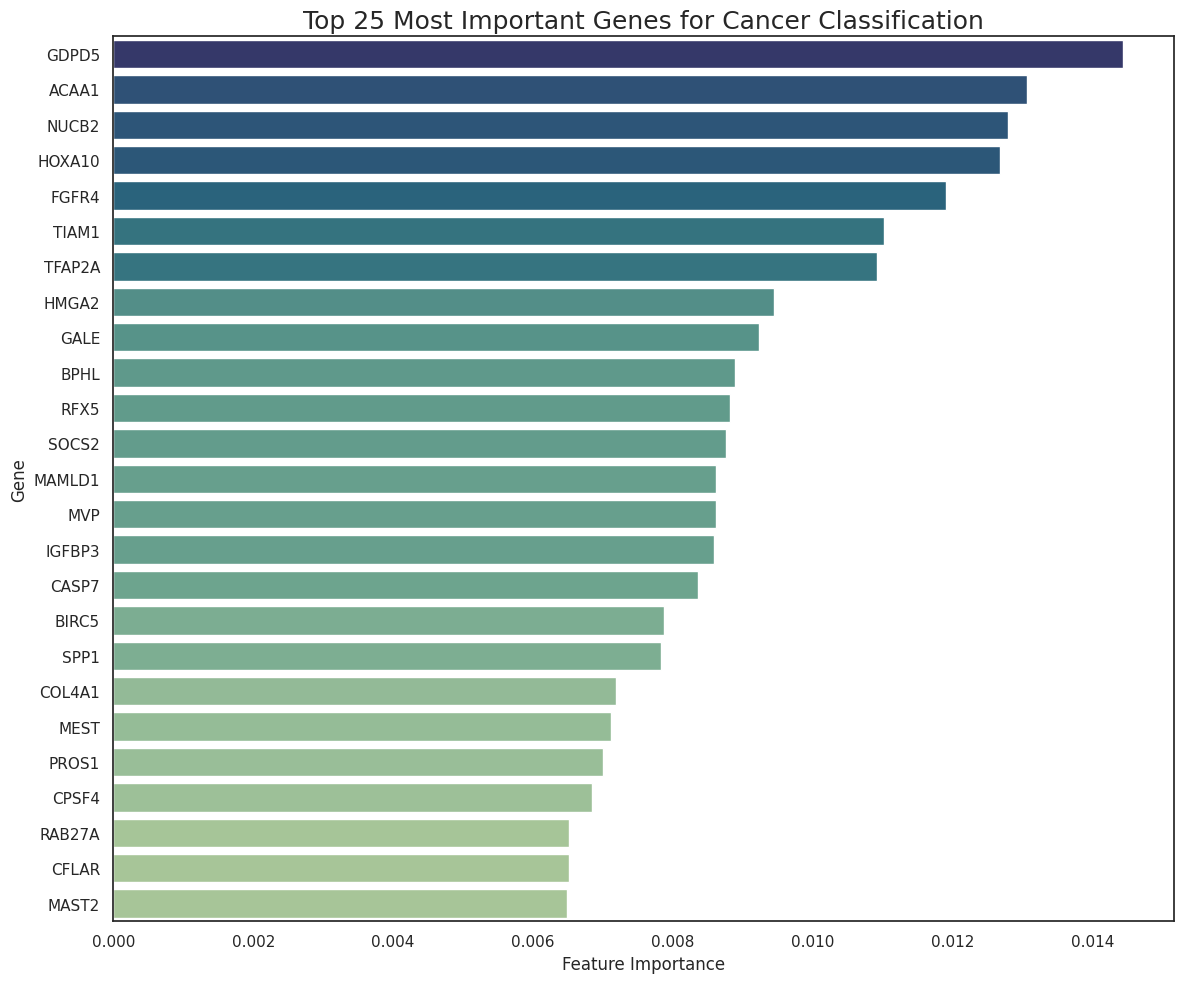

In [128]:
# --- get the retained, post-transform feature names ---
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

def get_retained_feature_names(pipeline: Pipeline, X_raw: pd.DataFrame):
    ct_name, ct = None, None
    for name, step in pipeline.named_steps.items():
        if isinstance(step, ColumnTransformer):
            ct_name, ct = name, step
            break

    if ct is not None:
        try:
            names = np.asarray(ct.get_feature_names_out(input_features=X_raw.columns))
        except Exception:
            names = np.asarray(ct.get_feature_names_out())
        boundary = ct_name
    else:
        # no ColumnTransformer; try first step or fall back to raw columns
        first_name, first_step = list(pipeline.named_steps.items())[0]
        if hasattr(first_step, "get_feature_names_out"):
            try:
                names = np.asarray(first_step.get_feature_names_out())
            except Exception:
                names = np.asarray(X_raw.columns)
        else:
            names = np.asarray(X_raw.columns)
        boundary = first_name

    # apply any downstream selectors (no dimensionality reducers)
    after = False
    for name, step in pipeline.named_steps.items():
        if name == boundary:
            after = True
            continue
        if not after or name == "classifier":
            if name == "classifier":  # stop right before classifier
                break
            continue
        if hasattr(step, "components_") or hasattr(step, "n_components_"):
            raise ValueError(
                f"Step '{name}' reduces dimension (e.g. PCA) so original names can't be mapped."
            )
        if hasattr(step, "get_support"):
            support = step.get_support()
            if support.dtype != bool:
                mask = np.zeros(len(names), dtype=bool)
                mask[np.asarray(support)] = True
                support = mask
            if support.shape[0] != len(names):
                raise ValueError(
                    f"Selector '{name}' mask length {support.shape[0]} != names length {len(names)}."
                )
            names = names[support]
    return names

clf = final_model.named_steps.get("classifier", None)
if not hasattr(clf, "feature_importances_"):
    raise AttributeError("The final estimator does not expose 'feature_importances_'.")

importances = clf.feature_importances_
final_names = get_retained_feature_names(final_model, X)

if len(final_names) != len(importances):
    raise RuntimeError(
        f"Name length ({len(final_names)}) != importances length ({len(importances)}). "
        "Check for unexpected reducers between preprocessor and classifier."
    )

feature_importance_df = (
    pd.DataFrame({"Gene": final_names, "Importance": importances})
      .sort_values("Importance", ascending=False)
      .reset_index(drop=True)
    )

print(f"Number of features used in final model: {len(importances)}")
display(feature_importance_df.head())

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.barplot(
    x="Importance",
    y="Gene",
    data=feature_importance_df.head(25),
    hue="Importance",
    palette="crest",
    legend=False
)
plt.title("Top 25 Most Important Genes for Cancer Classification", fontsize=18)
plt.xlabel("Feature Importance")
plt.ylabel("Gene")
plt.tight_layout()
save_fig("feature_importances_top25.png")
plt.show()


--- Performing Enrichment Analysis on Top 200 Genes ---
Using gene sets: KEGG_2021_Human, Reactome_2022, MSigDB_Hallmark_2020

--- Top Enriched Pathways ---
                  Gene_set                                               Term  \
0          KEGG_2021_Human                                 Pathways in cancer   
251          Reactome_2022                           Metabolism R-HSA-1430728   
1183  MSigDB_Hallmark_2020                             Estrogen Response Late   
252          Reactome_2022                         Immune System R-HSA-168256   
253          Reactome_2022  Signaling By Receptor Tyrosine Kinases R-HSA-9...   
254          Reactome_2022             Signaling By Interleukins R-HSA-449147   
255          Reactome_2022                  Innate Immune System R-HSA-168249   
1186  MSigDB_Hallmark_2020                              Xenobiotic Metabolism   
1184  MSigDB_Hallmark_2020                                          Apoptosis   
1185  MSigDB_Hallmark_2020       

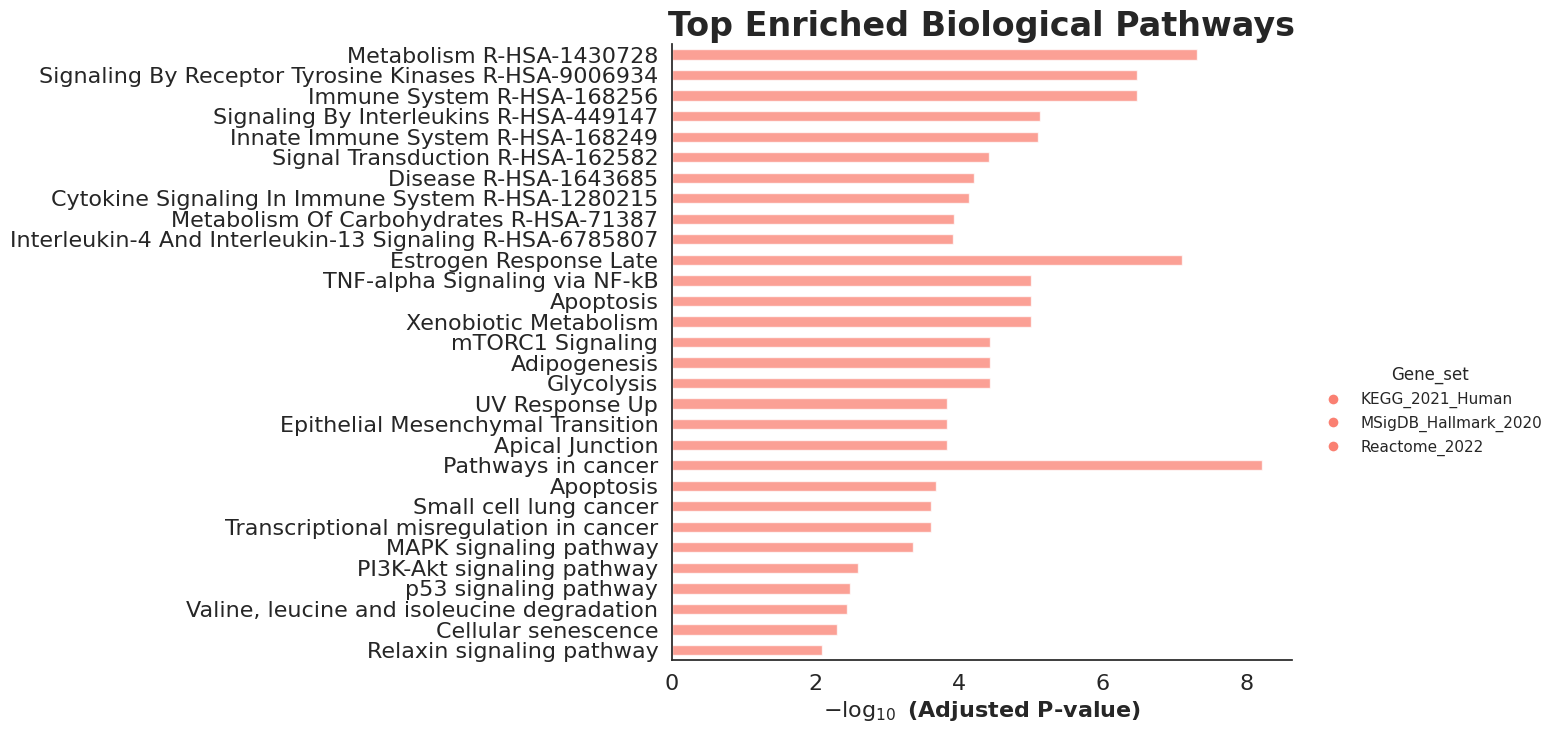

In [129]:
# Prep gene list (unique, uppercase strings) 
top_genes = pd.Series(feature_importance_df['Gene'].head(200), dtype=str).str.upper().dropna().unique().tolist()

gene_sets_to_use = ['KEGG_2021_Human', 'Reactome_2022', 'MSigDB_Hallmark_2020']
outdir = 'reports/enrichment'
os.makedirs(outdir, exist_ok=True)

print(f"--- Performing Enrichment Analysis on Top {len(top_genes)} Genes ---")
print(f"Using gene sets: {', '.join(gene_sets_to_use)}")

try:
    enr = gseapy.enrichr(
        gene_list=top_genes,
        gene_sets=gene_sets_to_use,
        organism='Human',
        outdir=outdir,
        cutoff=0.05  # adjusted p-value
    )

    # Handle result attribute across versions
    res = getattr(enr, 'results', None)
    if res is None:
        res = getattr(enr, 'res2d', None)

    if res is not None and not res.empty:
        # Try both common adj-p columns
        adjp_cols = [c for c in ['Adjusted P-value', 'Adjusted P-value (BH)', 'Adjusted P-value (Benjamini-Hochberg)', 'Adjusted P-value (FDR)'] if c in res.columns]
        pcol = adjp_cols[0] if adjp_cols else ('P-value' if 'P-value' in res.columns else None)

        if pcol is None:
            print("Enrichr results returned, but no recognized adjusted p-value column found.")
            display_cols = res.columns[:8]
        else:
            res = res.sort_values(pcol)
            display_cols = [col for col in ['Gene_set', 'Term', pcol, 'Overlap', 'Combined Score', 'Odds Ratio', 'Old P-value', 'Z-score', 'Genes'] if col in res.columns]

        print("\n--- Top Enriched Pathways ---")
        print(res[display_cols].head(15))

        # Plot barplot (falls back to pcol if available)
        try:
            ax = gseapy.barplot(
                res,
                column=(pcol if pcol is not None else 'P-value'),
                group='Gene_set' if 'Gene_set' in res.columns else None,
                size=6,
                top_term=10,
                figsize=(8, 8),
                title="Top Enriched Biological Pathways"
            )
            if ax is not None:
                save_fig("enrichment_barplot.png", fig=ax.figure)
                plt.show()
        except Exception as pe:
            print(f"(Plotting skipped — barplot error: {pe})")

    else:
        print("No significant pathways found with the current settings.")

except Exception as e:
    print(f"An error occurred during enrichment analysis: {e}")
    print("If this persists, check your internet connection, gene set names, and GSEApy version.")


In [130]:
res = res if 'res' in globals() else enr.results if hasattr(enr,'results') else enr.res2d
show_cols = ['Gene_set','Term','Adjusted P-value','Genes','Overlap','Combined Score','Odds Ratio']
display(res.sort_values('Adjusted P-value')[show_cols].head(15))

# Parse contributing genes for a chosen term
term = 'Pathways in cancer'
row = res.loc[res['Term'].str.contains(term, case=False)].sort_values('Adjusted P-value').head(1)
leading_genes = []
if not row.empty:
    leading_genes = sorted(set(row['Genes'].iloc[0].split(';')))
print(f"{term} leading genes ({len(leading_genes)}):", leading_genes[:30])


Gene_set                                               Term  \
0          KEGG_2021_Human                                 Pathways in cancer   
251          Reactome_2022                           Metabolism R-HSA-1430728   
1183  MSigDB_Hallmark_2020                             Estrogen Response Late   
252          Reactome_2022                         Immune System R-HSA-168256   
253          Reactome_2022  Signaling By Receptor Tyrosine Kinases R-HSA-9...   
254          Reactome_2022             Signaling By Interleukins R-HSA-449147   
255          Reactome_2022                  Innate Immune System R-HSA-168249   
1186  MSigDB_Hallmark_2020                              Xenobiotic Metabolism   
1184  MSigDB_Hallmark_2020                                          Apoptosis   
1185  MSigDB_Hallmark_2020                      TNF-alpha Signaling via NF-kB   
1189  MSigDB_Hallmark_2020                                         Glycolysis   
1187  MSigDB_Hallmark_2020                                       Adipogenesis   
1188  MSigDB_Hallmark_2020                                   mTORC1 Signaling   
256          Reactome_2022                   Signal Transduction R-HSA-162582   
257          Reactome_2022                              Disease R-HSA-1643685   

      Adjusted P-value                                              Genes  \
0         6.043529e-09  LAMA3;GNAI1;GLI2;CASP7;CCND1;AKT1;HMOX1;BID;SK...   
251       4.890883e-08  LPGAT1;CLSTN1;FHL2;PYGL;ETFB;HS2ST1;MPC2;AKT1;...   
1183      7.861019e-08  SCARB1;ST6GALNAC2;WFS1;DYNLT3;SLC1A4;ETFB;MAPK...   
252       3.314031e-07  PROS1;CLTC;CLSTN1;PYGL;FBXO21;CXCL2;CCND1;VPS7...   
253       3.314031e-07  DUSP4;GRB7;CLTC;ADAM10;PTK2;DUSP6;MAPK13;FOSL1...   
254       7.350777e-06  DUSP4;PSMD10;IL4R;CEBPD;MMP1;CLSTN1;GATA3;CXCL...   
255       8.037822e-06  PSMD10;ASAH1;GRN;PROS1;PYGL;VPS72;RPS6KA1;HMOX...   
1186      9.784166e-06  CBR1;UGDH;SLC35B1;ID2;PROS1;NMT1;HMOX1;APOE;FA...   
1184      9.784166e-06  CASP7;GNA15;CCND1;GADD45B;ERBB3;HMOX1;CASP2;CF...   
1185      9.784166e-06  FOSL1;DUSP4;GADD45B;CCND1;CEBPD;TNIP1;ID2;BHLH...   
1189      3.738484e-05  GALE;GNPDA1;AGL;IGFBP3;COG2;PYGL;NOL3;SLC37A4;...   
1187      3.738484e-05  SLC5A6;SCARB1;ACLY;COL4A1;NMT1;ELOVL6;APOE;ETF...   
1188      3.738484e-05  ACLY;TXNRD1;BHLHE40;NMT1;PHGDH;ELOVL6;SLC1A4;S...   
256       3.841807e-05  CLTC;CLSTN1;IKZF1;CXCL2;GLI2;CCND1;VPS72;GPER1...   
257       6.230419e-05  PSMD10;DNMT1;ST6GALNAC2;CEBPD;CLTC;CLSTN1;GNAI...   

      Overlap  Combined Score  Odds Ratio  
0      26/531      139.589124    5.709230  
251   53/2049       76.124701    3.215997  
1183   15/200      173.546808    8.596786  
252   49/1943       64.144870    3.067876  
253    23/496      109.688181    5.309552  
254    20/453       85.835732    4.969720  
255   31/1035       58.238916    3.434051  
1186   12/200       93.068832    6.658669  
1184   11/161      108.221356    7.624339  
1185   12/200       93.068832    6.658669  
1189   11/200       72.933498    6.039053  
1187   11/200       72.933498    6.039053  
1188   11/200       72.933498    6.039053  
256   51/2465       37.501489    2.465167  
257   40/1736       38.895058    2.668632

Pathways in cancer leading genes (26): ['AKT1', 'ARNT2', 'BID', 'BIRC2', 'BIRC5', 'CASP7', 'CCND1', 'COL4A1', 'DDB2', 'FGFR2', 'FGFR4', 'GADD45B', 'GLI2', 'GNAI1', 'GNB5', 'HMOX1', 'IL13RA1', 'IL4R', 'KIT', 'LAMA3', 'MMP1', 'PAX8', 'PPARD', 'PTK2', 'SKP1', 'TXNRD1']


Saved figure to /home/kousis/work/BCProjects/drugs_plots/enrichment_scatter.png


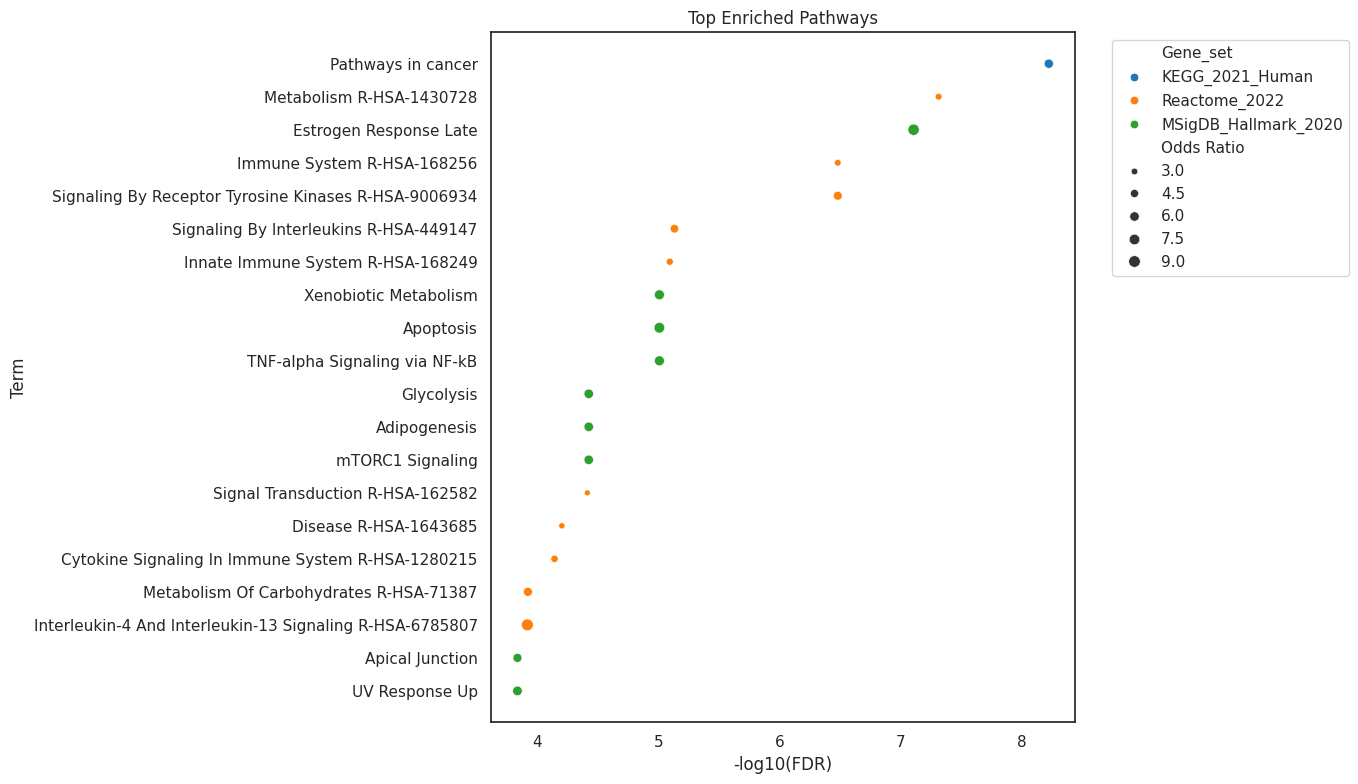

In [131]:
tmp = res.sort_values('Adjusted P-value').head(20).copy()
tmp['-log10(FDR)'] = -np.log10(tmp['Adjusted P-value'].clip(lower=1e-300))
plt.figure(figsize=(14,8))
sns.scatterplot(data=tmp, x='-log10(FDR)', y='Term', size='Odds Ratio', hue='Gene_set')
plt.title('Top Enriched Pathways')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
save_fig("enrichment_scatter.png")
plt.show()


In [132]:
# LINCS Drug Signature Prediction — ALL signatures, batch + progress, pipeline-safe
# Uses feature_importance_df for coverage/reporting only (no feature trimming)
# For this block LLM were used heavily to help with detecting parsing, batching, and pipeline issues.
# Manually Curated 

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from cmapPy.pandasGEXpress.parse import parse  # pip install cmapPy

# conf
LINCS_DIR = '/home/kousis/work/Chavlis/data/lincs'
SIG_INFO_PATH = os.path.join(LINCS_DIR, 'GSE92742_Broad_LINCS_sig_info.txt.gz')
GENE_INFO_PATH = os.path.join(LINCS_DIR, 'GSE92742_Broad_LINCS_gene_info.txt.gz')
GCTX_PATH = os.path.join(LINCS_DIR, 'GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx')

OUTDIR = 'reports'
BATCH_SIZE = 10_000  # tune for RAM/IO


MODEL_GENES_CSV = os.environ.get('MODEL_GENES_CSV', None)  # CSV with column 'gene'

# shut up pandas warnings
if not hasattr(pd, "_to_numeric_orig_compat"):
    pd._to_numeric_orig_compat = pd.to_numeric
    def _to_numeric_compat(x, *args, **kwargs):
        if kwargs.get("errors") == "ignore":
            kwargs.pop("errors", None)
            try:
                return pd._to_numeric_orig_compat(x, *args, **kwargs)
            except Exception:
                return x
        return pd._to_numeric_orig_compat(x, *args, **kwargs)
    pd.to_numeric = _to_numeric_compat


# Start
print("--- Starting LINCS Drug Signature Prediction (ALL signatures) ---")

#  Helpers 
def norm_syms(seq):
    return pd.Index(pd.Series(seq, dtype=str).str.upper().str.replace(' ', '', regex=False))

def resolve_model_genes():
    # base gene list (training input order)
    if 'MODEL_GENES' in globals() and isinstance(globals()['MODEL_GENES'], (list, tuple, pd.Index)):
        genes = pd.Index([str(g) for g in globals()['MODEL_GENES']])
        if len(genes) == 0:
            raise RuntimeError("MODEL_GENES is defined but empty.")
        return genes
    if MODEL_GENES_CSV and os.path.exists(MODEL_GENES_CSV):
        df = pd.read_csv(MODEL_GENES_CSV)
        if 'gene' not in df.columns:
            raise RuntimeError(f"{MODEL_GENES_CSV} must contain a 'gene' column.")
        genes = pd.Index(df['gene'].astype(str))
        if len(genes) == 0:
            raise RuntimeError(f"No genes found in {MODEL_GENES_CSV}.")
        return genes
    if 'final_model' in globals() and hasattr(final_model, 'feature_names_in_'):
        genes = pd.Index([str(g) for g in final_model.feature_names_in_])
        if len(genes) == 0:
            raise RuntimeError("final_model.feature_names_in_ exists but is empty.")
        return genes
    raise RuntimeError("Could not resolve model features. Provide MODEL_GENES / MODEL_GENES_CSV / feature_names_in_.")

def _step_has_selector(step):
    return hasattr(step, "get_support")

def model_requires_base_width(model):
    # If pipeline has any selector, or first transformer learned n_features_in_, feed base width.
    try:
        from sklearn.pipeline import Pipeline
    except Exception:
        Pipeline = tuple()
    if isinstance(model, Pipeline):
        for _, step in model.named_steps.items():
            if _step_has_selector(step):
                return True
        # If first transformer reports learned width, prefer base
        for _, step in model.named_steps.items():
            if hasattr(step, "n_features_in_"):
                return True
        return False
    # Non-pipeline: if it learned n_features_in_, prefer base
    return hasattr(model, "n_features_in_")

def resolve_active_features(model, base_names):
    # Best-effort to discover selected features (for reporting). No trimming for input here.
    try:
        from sklearn.pipeline import Pipeline
    except Exception:
        Pipeline = tuple()
    names = pd.Index(base_names)
    if isinstance(model, Pipeline):
        for _, step in model.named_steps.items():
            if hasattr(step, "get_feature_names_out"):
                try:
                    names = pd.Index(step.get_feature_names_out(input_features=names))
                    continue
                except TypeError:
                    try:
                        names = pd.Index(step.get_feature_names_out())
                        continue
                    except Exception:
                        pass
            if hasattr(step, "get_support"):
                try:
                    mask = np.asarray(step.get_support(), dtype=bool)
                    if mask.size == len(names):
                        names = names[mask]
                except Exception:
                    pass
        return names
    if hasattr(model, "get_support"):
        try:
            mask = np.asarray(model.get_support(), dtype=bool)
            if mask.size == len(names):
                return names[mask]
        except Exception:
            pass
    return names

def resolve_classes_and_proba_fn():
    if 'le' in globals() and hasattr(le, 'classes_'):
        classes = np.array(le.classes_)
    elif 'final_model' in globals() and hasattr(final_model, 'classes_'):
        classes = np.array(final_model.classes_)
    else:
        raise RuntimeError("Provide a fitted LabelEncoder 'le' or ensure final_model.classes_ exists.")
    if hasattr(final_model, 'predict_proba'):
        def proba_fn(Xb): return final_model.predict_proba(Xb)
    elif hasattr(final_model, 'decision_function'):
        def proba_fn(Xb):
            scores = np.asarray(final_model.decision_function(Xb))
            if scores.ndim == 1 or (scores.ndim == 2 and scores.shape[1] == 1):
                s = scores.ravel()
                p1 = 1. / (1. + np.exp(-s))
                p0 = 1. - p1
                return np.column_stack([p0, p1])
            e = np.exp(scores - np.max(scores, axis=1, keepdims=True))
            return e / e.sum(axis=1, keepdims=True)
    else:
        raise RuntimeError("Model has neither predict_proba nor decision_function.")
    return classes, proba_fn

# Load metadata
print("Loading LINCS metadata...")
sig_info = pd.read_csv(SIG_INFO_PATH, sep='\t', engine='python', on_bad_lines='skip', compression='infer')
gene_info = pd.read_csv(GENE_INFO_PATH, sep='\t', engine='python', dtype={'pr_gene_id': str}, compression='infer')

for cols, name in [({'sig_id','pert_type','pert_iname'}, 'sig_info'),
                   ({'pr_gene_id','pr_gene_symbol','pr_is_lm'}, 'gene_info')]:
    miss = cols - set(eval(name).columns)
    if miss: raise ValueError(f"{name} missing columns: {miss}")

drug_signatures = sig_info.loc[sig_info['pert_type'] == 'trt_cp'].copy()
if len(drug_signatures) == 0:
    raise RuntimeError("No compound signatures after filtering.")

# Resolve features, pick input width
base_genes = resolve_model_genes()# training input order (e.g., 655)
active_genes = resolve_active_features(final_model, base_genes)  # discovered selected (e.g., 591)

# normalize
base_genes = pd.Index(base_genes)
active_genes = pd.Index(active_genes)
base_norm = norm_syms(base_genes)
active_norm = norm_syms(active_genes)

print(f"Model input (base): {len(base_genes)}; discovered active: {len(active_genes)}")

# Decide width to FEED the pipeline (we do NOT reduce to “top genes” here)
use_base = model_requires_base_width(final_model)
genes_for_alignment = base_genes if use_base else active_genes
genes_norm = base_norm if use_base else active_norm
mode_label = "BASE" if use_base else "ACTIVE"
print(f"Prediction input width: {mode_label} ({len(genes_for_alignment)} features)")

# Optional: feature importance genes for coverage reporting
importance_genes = None
if 'feature_importance_df' in globals() and 'Gene' in feature_importance_df.columns:
    # You can feed head(200) or full — we’ll just normalize & use for coverage/order (no trimming).
    importance_genes = norm_syms(feature_importance_df['Gene'])
    # Coverage vs chosen input genes
    overlap = pd.Index(genes_norm).intersection(importance_genes)
    print(f"Feature importance provided: {len(importance_genes)} names; overlap with input set: {len(overlap)}")

# Map to pr_gene_id, ensure all landmarks
landmarks = pd.Index(norm_syms(gene_info.loc[gene_info['pr_is_lm'] == 1, 'pr_gene_symbol'].astype(str)).unique())
not_lm = genes_for_alignment[~genes_norm.isin(landmarks)]
if len(not_lm) > 0:
    raise RuntimeError(f"Chosen gene set contains non-landmarks: examples {not_lm[:10].tolist()}")

sym_to_id = (gene_info[['pr_gene_symbol','pr_gene_id','pr_is_lm']]
             .dropna().drop_duplicates(subset=['pr_gene_symbol'])
             .set_index('pr_gene_symbol'))
sym_to_id_norm = sym_to_id.copy()
sym_to_id_norm.index = norm_syms(sym_to_id_norm.index)

missing_ids = genes_norm.difference(sym_to_id_norm.index)
if len(missing_ids) > 0:
    raise RuntimeError(f"Could not map some genes to pr_gene_id: {missing_ids[:10].tolist()}")

rids_in_model_order = sym_to_id_norm.loc[genes_norm, 'pr_gene_id'].tolist()
print(f"Prepared {len(rids_in_model_order)} landmark RIDs in prediction order ({mode_label}).")

# setup 
cids = drug_signatures['sig_id'].astype(str).tolist()
n_total = len(cids)
print(f"Selected ALL {n_total} drug signatures for extraction/prediction.")

if not os.path.exists(GCTX_PATH):
    raise FileNotFoundError(f"GCTX not found: {GCTX_PATH}")

os.makedirs(OUTDIR, exist_ok=True)
suffix = f"input{len(genes_for_alignment)}_active{len(active_genes)}"
out_path = os.path.join(OUTDIR, f"lincs_drug_predictions_{suffix}.csv")

# resume-safe header logic
wrote_header = os.path.exists(out_path) and os.path.getsize(out_path) > 0

drug_meta_by_sig = drug_signatures.set_index('sig_id')
rid_to_symbol = gene_info.set_index('pr_gene_id')['pr_gene_symbol']
classes, proba_fn = resolve_classes_and_proba_fn()

top_k = 10
rolling_best = None

# Batch loop
print("Extracting, aligning, predicting in batches...")
for i in tqdm(range(0, n_total, BATCH_SIZE),
              total=(n_total + BATCH_SIZE - 1)//BATCH_SIZE, desc="Batches"):
    batch_cids = cids[i:i+BATCH_SIZE]

    gctx = parse(GCTX_PATH, cid=batch_cids, rid=rids_in_model_order)
    lincs_df = gctx.data_df.copy()  # rows=rids, cols=cids

    # map RID symbol and normalize
    lincs_df.index = lincs_df.index.map(rid_to_symbol)  # original casing
    lincs_df.index = norm_syms(lincs_df.index)

    # align to chosen genes and transpose (samples x features)
    lincs_aligned = lincs_df.loc[genes_norm].T
    lincs_aligned.columns = genes_for_alignment.values  # restore original casing
    lincs_aligned = lincs_aligned.astype(np.float32)

    if lincs_aligned.isna().any().any():
        raise RuntimeError("Found NaNs after alignment; unexpected for landmark-only. Check mapping/filters.")

    # predict probabilities
    proba = proba_fn(lincs_aligned)
    if proba.shape[1] != len(classes):
        raise RuntimeError(f"Model returned {proba.shape[1]} prob columns but classes has {len(classes)}.")
    proba_df = pd.DataFrame(proba, index=lincs_aligned.index, columns=classes)

    # metadata in prediction order
    order_df = pd.DataFrame({'sig_id': lincs_aligned.index})
    meta_sub = order_df.join(drug_meta_by_sig, on='sig_id')

    wanted_cols = ['sig_id', 'pert_iname', 'moa', 'cell_id', 'pert_dose', 'pert_time']
    present_cols = [c for c in wanted_cols if c in meta_sub.columns]
    if 'sig_id' not in present_cols:
        present_cols = ['sig_id'] + present_cols

    results_df = pd.concat([meta_sub[present_cols].reset_index(drop=True),
                            proba_df.reset_index(drop=True)], axis=1)
    results_df['max_prob'] = results_df[classes].max(axis=1)
    results_df['predicted_cancer'] = results_df[classes].idxmax(axis=1)

    # (Optional) attach importance rank for columns present (for downstream analysis)
    if importance_genes is not None:
        imp_map = {g:i for i,g in enumerate(importance_genes)}
        col_norm = norm_syms(results_df.columns)


    # stream-append to CSV
    results_df.to_csv(out_path, mode='a', index=False, header=not wrote_header)
    wrote_header = True

    # update rolling Top-10
    keep_cols = [c for c in ['pert_iname','moa','predicted_cancer','max_prob'] if c in results_df.columns]
    batch_top = results_df.nlargest(top_k, 'max_prob')[keep_cols]
    if rolling_best is None:
        rolling_best = batch_top
    else:
        rolling_best = (pd.concat([rolling_best, batch_top], axis=0)
                          .nlargest(top_k, 'max_prob'))

print(f"\nSUCCESS: Predictions saved to: {out_path}")

--- Starting LINCS Drug Signature Prediction (ALL signatures) ---
Loading LINCS metadata...
Model input (base): 655; discovered active: 591
Prediction input width: BASE (655 features)
Feature importance provided: 591 names; overlap with input set: 591
Prepared 655 landmark RIDs in prediction order (BASE).
Selected ALL 205034 drug signatures for extraction/prediction.
Extracting, aligning, predicting in batches...
Model input (base): 655; discovered active: 591
Prediction input width: BASE (655 features)
Feature importance provided: 591 names; overlap with input set: 591
Prepared 655 landmark RIDs in prediction order (BASE).
Selected ALL 205034 drug signatures for extraction/prediction.
Extracting, aligning, predicting in batches...


Batches: 100%|██████████| 21/21 [01:12<00:00,  3.45s/it]


SUCCESS: Predictions saved to: reports/lincs_drug_predictions_input655_active591.csv


Saved figure to /home/kousis/work/BCProjects/drugs_plots/drug_top_probabilities_grid.png


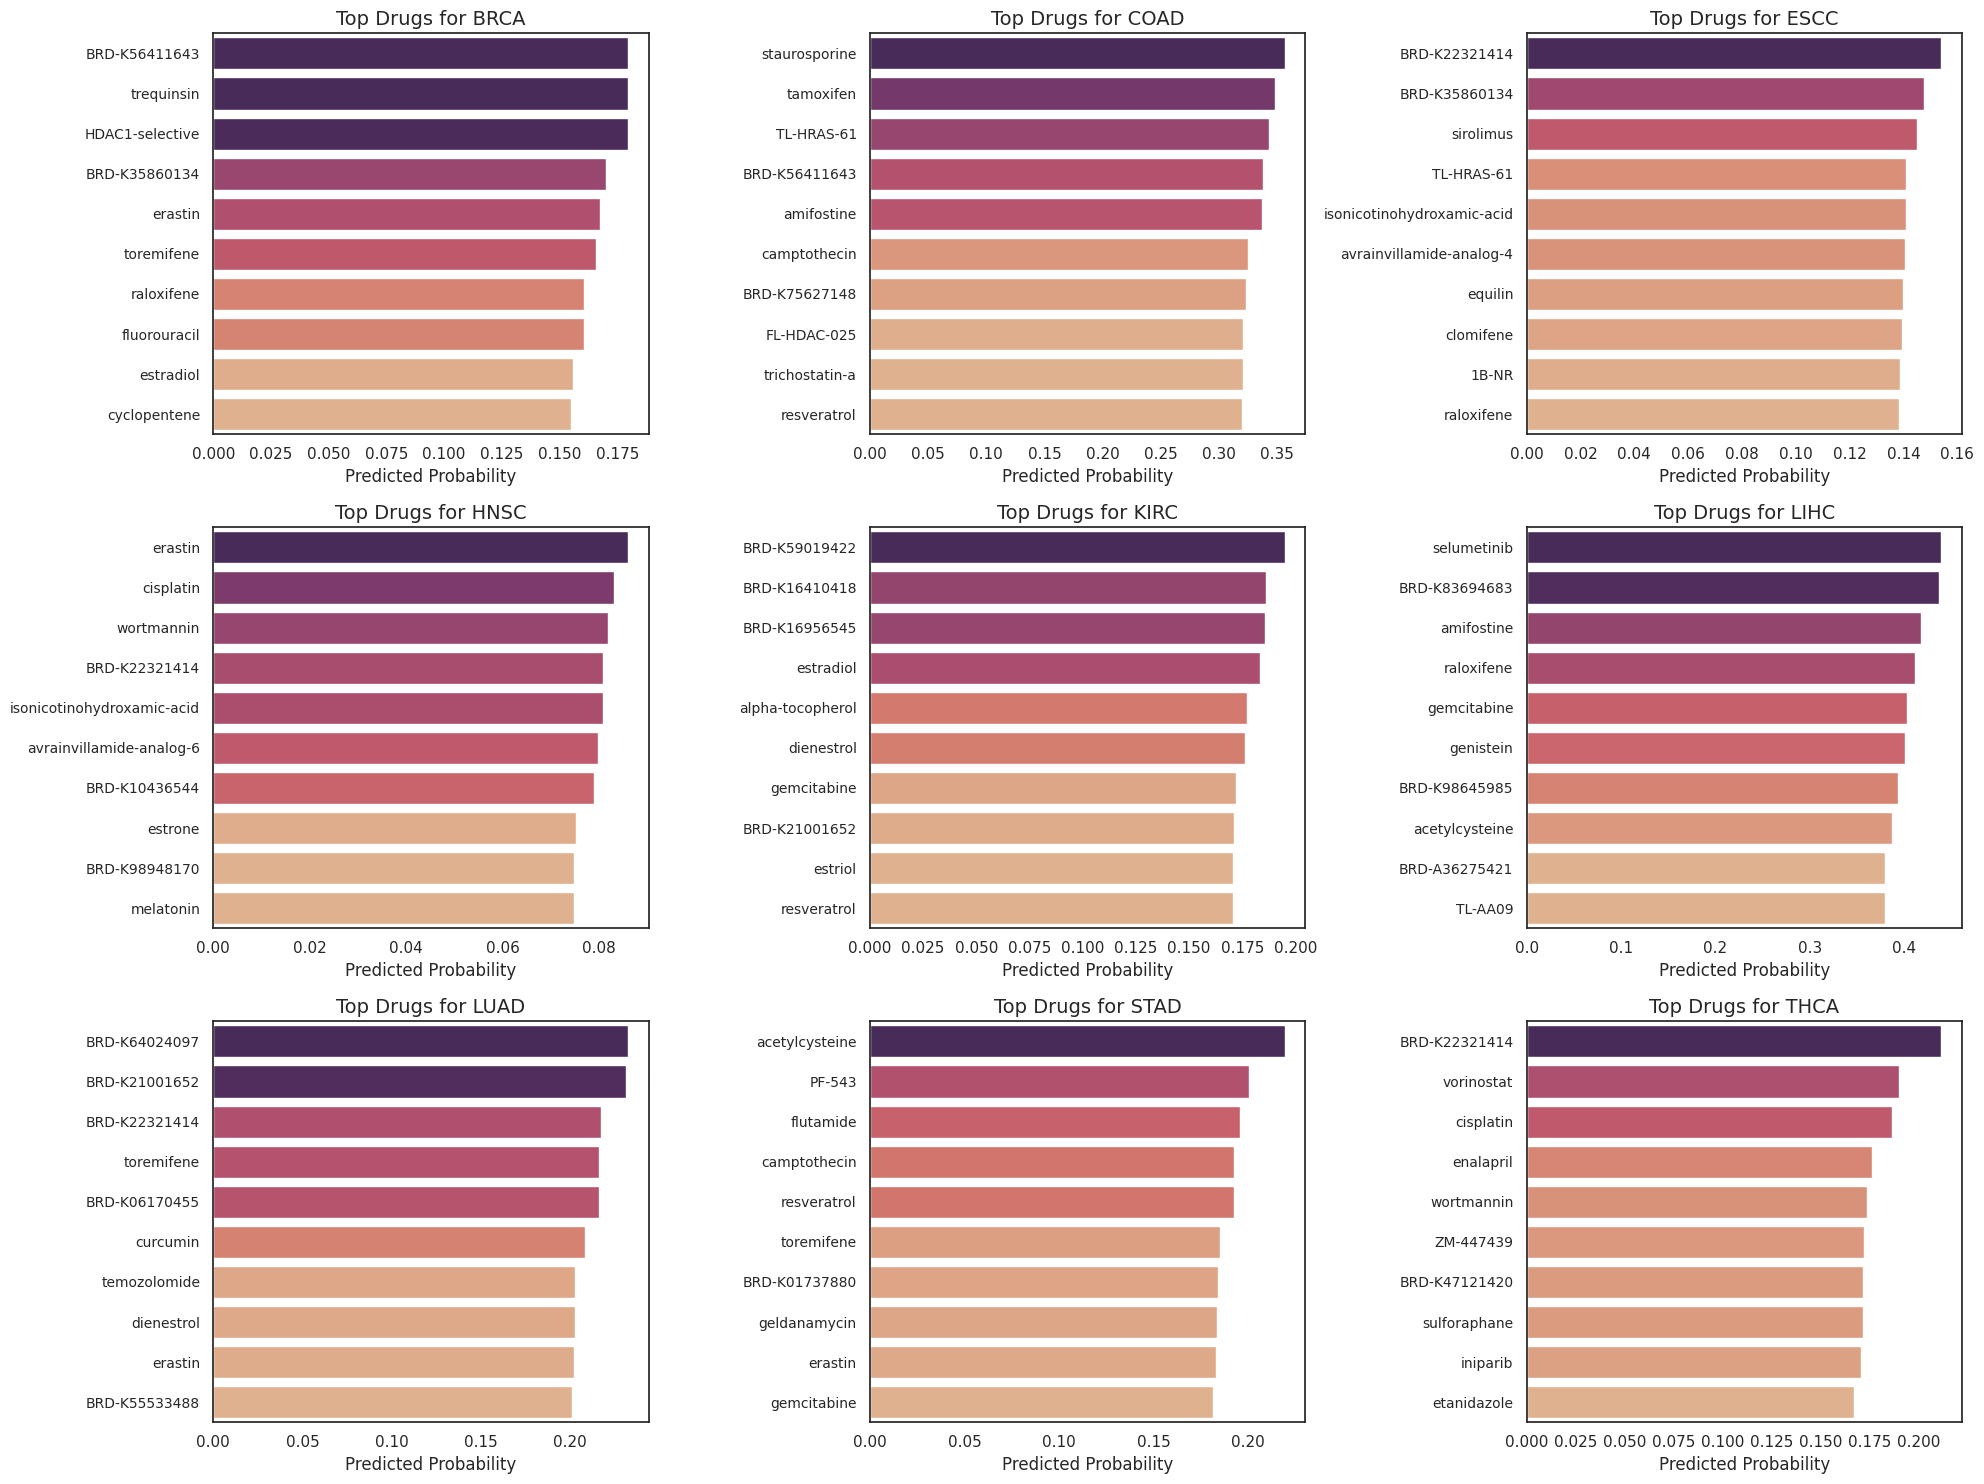

In [133]:
if 'results_df' in locals():
    # Group by compound name and take the max probability across all its signatures
    # This gives a single "best-shot" score for each unique drug
    drug_summary = results_df.groupby('pert_iname')[le.classes_].max().reset_index()

    n_cancers = len(le.classes_)
    # Create a grid of plots
    fig, axes = plt.subplots(nrows=(n_cancers + 2) // 3, ncols=3, figsize=(20, 5 * ((n_cancers + 2) // 3)))
    axes = axes.flatten()

    for i, cancer_type in enumerate(le.classes_):
        ax = axes[i]
        # Find top 10 drugs for this cancer type
        top_drugs = drug_summary.sort_values(by=cancer_type, ascending=False).head(10)
        
        sns.barplot(x=cancer_type, y='pert_iname', data=top_drugs, ax=ax, palette='flare',hue=cancer_type, legend=False)
        ax.set_title(f"Top Drugs for {cancer_type}", fontsize=14)
        ax.set_xlabel("Predicted Probability")
        ax.set_ylabel("")
        ax.tick_params(axis='y', labelsize=10)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    save_fig("drug_top_probabilities_grid.png", fig=fig)
    plt.show()

## Supplements

/home/kousis/miniconda3/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.

/home/kousis/miniconda3/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



Saved figure to /home/kousis/work/BCProjects/drugs_plots/lincs_random_clustermap.png


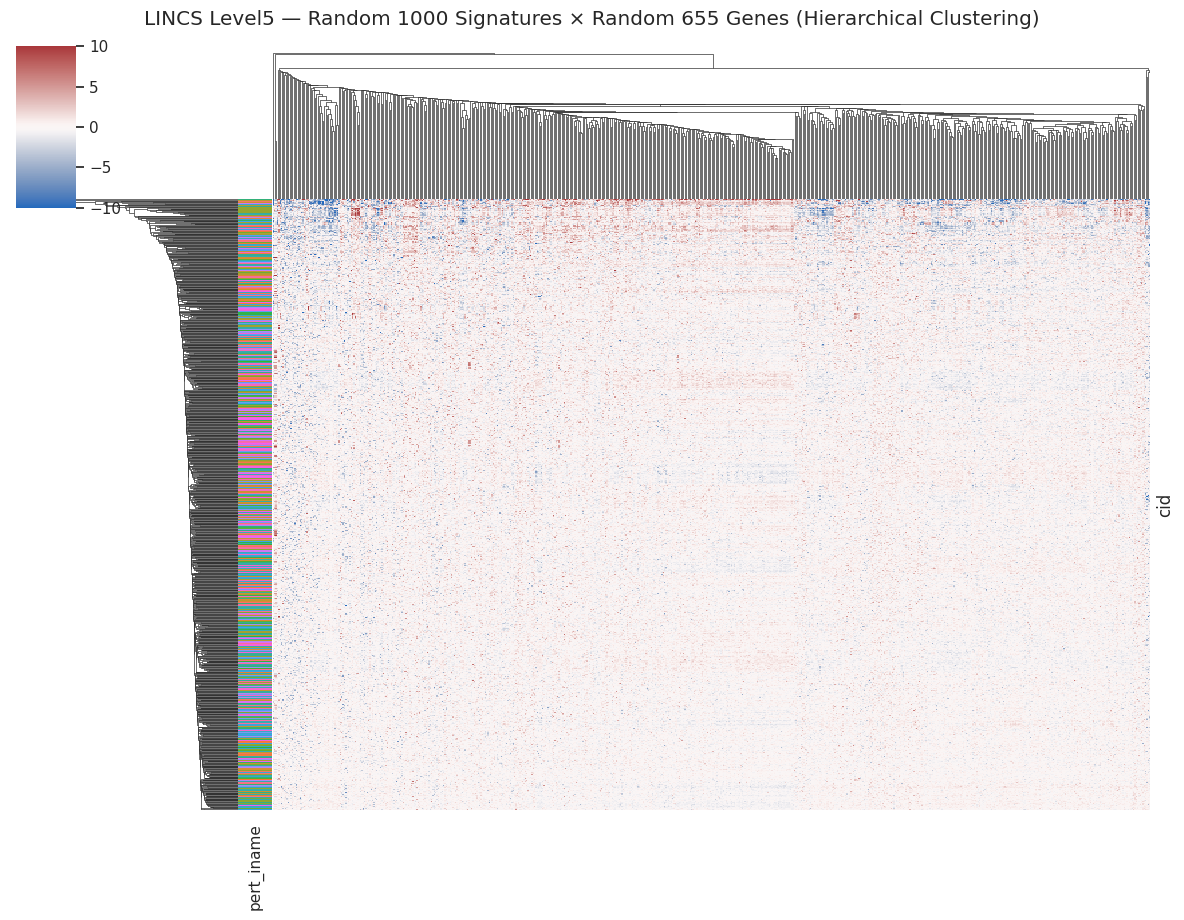

In [134]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from cmapPy.pandasGEXpress.parse import parse

LINCS_DIR = '/home/kousis/work/Chavlis/data/lincs'
SIG_INFO_PATH = os.path.join(LINCS_DIR, 'GSE92742_Broad_LINCS_sig_info.txt.gz')
GENE_INFO_PATH = os.path.join(LINCS_DIR, 'GSE92742_Broad_LINCS_gene_info.txt.gz')
GCTX_PATH = os.path.join(LINCS_DIR, 'GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx')

# conf
rng_seed = 42 # set to None for different draws each run
n_samples = 1000 # number of LINCS signatures (rows)
n_genes = 900 # number of genes (columns)

sig_info = pd.read_csv(SIG_INFO_PATH, sep='\t', low_memory=False)

gene_info = pd.read_csv(
    GENE_INFO_PATH, sep='\t',
    usecols=['pr_gene_id', 'pr_gene_symbol', 'pr_is_lm']
).dropna(subset=['pr_gene_symbol'])

gene_map = (
    gene_info
    .set_index('pr_gene_id')['pr_gene_symbol']
    .loc[~gene_info['pr_gene_id'].duplicated().values]
)

target_cell = 'A549'           
target_time = '24 h'            
target_pert_types = ['trt_cp']  

def normalize_time_to_h(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, (int, float, np.integer, np.floating)):
        return f'{int(x)} h'
    s = str(x).strip().lower()
    s = (s.replace('hours', 'h')
           .replace('hour', 'h')
           .replace('hrs', 'h')
           .replace('hr', 'h')
           .replace(' ', ''))
    if s.endswith('h'):
        digits = ''.join(ch for ch in s if ch.isdigit())
        return f'{int(digits)} h' if digits else np.nan
    digits = ''.join(ch for ch in s if ch.isdigit())
    return f'{int(digits)} h' if digits else np.nan

sig_info = sig_info.copy()
sig_info['pert_time_norm'] = sig_info['pert_time'].apply(normalize_time_to_h)


subset_pool = (
    sig_info[
        sig_info['cell_id'].eq(target_cell)
        & sig_info['pert_type'].isin(target_pert_types)
        & sig_info['pert_time_norm'].eq(normalize_time_to_h(target_time))
    ]
    .set_index('sig_id')
)

if subset_pool.empty:
    raise ValueError(
        f'No LINCS signatures matched filters. '
        f'cell_id={target_cell}, pert_type in {target_pert_types}, pert_time={target_time}.'
)

subset_info = subset_pool.sample(
    n=min(n_samples, len(subset_pool)),
    random_state=rng_seed,
    replace=False
)
cids = subset_info.index.tolist()

try:
    feature_order  
except NameError:
    feature_order = pd.Index(
        gene_info.loc[gene_info['pr_is_lm'] == 1, 'pr_gene_symbol'].unique()
)

# overlap between your feature set and LINCS symbols
shared_gene_symbols = pd.Index(feature_order).intersection(gene_map.values)
if shared_gene_symbols.empty:
    raise ValueError('No overlap between LINCS genes and the feature set (feature_order).')


gene_map_subset = gene_map[gene_map.isin(shared_gene_symbols)]
gene_map_subset = gene_map_subset[~gene_map_subset.index.duplicated(keep='first')]
gene_map_subset_str = gene_map_subset.copy()
gene_map_subset_str.index = gene_map_subset_str.index.astype(str)

avail_gene_ids = pd.Index(gene_map_subset_str.index)
n_pick = min(n_genes, len(avail_gene_ids))
rng = np.random.default_rng(rng_seed)
rid = rng.choice(avail_gene_ids, size=n_pick, replace=False).tolist()

gctx = parse(GCTX_PATH, cid=cids, rid=rid)

lincs_matrix = gctx.data_df.loc[rid, cids]

idx_as_str = pd.Index(lincs_matrix.index.astype(str))
id_hit_ratio = idx_as_str.isin(gene_map_subset_str.index).mean()

if id_hit_ratio > 0.9:
    lincs_matrix.index = gene_map_subset_str.loc[idx_as_str].values
else:
    lincs_matrix.index = lincs_matrix.index.astype(str)

# Deduplicate symbols (keep first)
lincs_matrix = lincs_matrix[~lincs_matrix.index.duplicated(keep='first')]


X_lincs = lincs_matrix.T.copy()
X_lincs_scaled = pd.DataFrame(
    X_lincs,
    index=X_lincs.index,
    columns=X_lincs.columns,
)

# These are already random genes from above
H_lincs = X_lincs_scaled # This is not scaled further since LINCS Level5 is already normalized 

row_labels = subset_info['pert_iname'].reindex(H_lincs.index)
palette = sns.color_palette('husl', n_colors=max(int(row_labels.nunique()), 1))
label_to_color = dict(zip(row_labels.dropna().unique(), palette))
row_colors = row_labels.map(label_to_color)

sns.set_context('notebook')
g = sns.clustermap(
    H_lincs,
    cmap='vlag',
    row_colors=row_colors,
    linewidths=0.0,
    xticklabels=False,
    yticklabels=False,
    figsize=(12, 9),
)


g.fig.suptitle(
    f'LINCS Level5 — Random {len(cids)} Signatures × Random {H_lincs.shape[1]} Genes (Hierarchical Clustering)',
    y=1.02
)
save_fig("lincs_random_clustermap.png", fig=g.fig)
plt.show()